In [1]:
from BCS_BEC_lib import *

In [2]:
#from matplotlib import plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

plt.style.use(['tableau-colorblind10'])
font = {'family' : 'sans serif',
        'weight' : 'regular',
        'size'   : 7}
mpl.rc('font', **font) 
mpl.rcParams['lines.linewidth'] = 0.66
mpl.rcParams['lines.markersize'] = 3
figsize=(3.375,4)
plt.rcParams["figure.figsize"] = figsize
plt.rcParams["figure.dpi"] = 200

from scipy import fft, ifft


In [3]:
def homogeneous_chain(LL, t, v, u0, PBC):
    if PBC:
        ts = [-t]*LL
    else:
        ts = [0]+([-t]*(LL-1))
    vs = [v]*LL
    u0s= [u0]*LL
    
    return ts, u0s, vs

def segmented_chain(LL_list, t_list, v_list, u0_list, t_int_list):
    assert len(LL_list)==len(t_list)==len(v_list)==len(u0_list)==len(t_int_list), "Lengths of supplied parameters not consistent"
    ts, vs, u0s = [], [], []
    for t, t_int, v, u0, LL in zip(t_list, t_int_list, v_list, u0_list, LL_list):
        ts += [-t_int]+[-t]*(LL-1)
        vs += [v]*LL
        u0s += [u0]*LL
    return ts, u0s, vs    

In [13]:
def symmetric_SNS_junction(LS, LN, V, t, U0S, U0N, delphi, edge_sites_with_fixed_phase=5):
    LL_list = [LS, LN, LS]
    t_list = [t, t, t]
    v_list = [V, 0, V]
    u0_list = [U0S, U0N, U0S]
    t_int_list = [0, t, t]
    
    ts, u0s, vs = segmented_chain(LL_list, t_list, v_list, u0_list, t_int_list)
    LL = np.sum(LL_list)
        
    def constrain_phase(Delta):
        Delta = Delta*np.exp(-1j*np.angle(Delta[0]))
        Delta[:edge_sites_with_fixed_phase]=np.abs(Delta[:edge_sites_with_fixed_phase])
        Delta[-edge_sites_with_fixed_phase:]=np.abs(Delta[-edge_sites_with_fixed_phase:])*np.exp(1j*delphi)
        return Delta
    
    return TBmodel(LL, ts, u0s, vs, constrain_phase=constrain_phase, Delta_init=Delta_init)

class SNS_junction:
    def __init__(self, LS, LN, V, t, U0S, U0N, edge_sites_with_fixed_phase=5):
        self.LS=LS
        self.LN=LN
        self.V=V
        self.t=t
        self.U0S=U0S
        self.U0N=U0N
        self.edge_sites_with_fixed_phase=edge_sites_with_fixed_phase
        self.LL_list = [LS, LN, LS]
        self.t_list = [t, t, t]
        self.v_list = [V, 0, V]
        self.u0_list = [U0S, U0N, U0S]
        self.t_int_list = [0, t, t]
        self.LL = np.sum(self.LL_list)

    def constrain_phase(self, Delta, delphi):
        Delta = Delta*np.exp(-1j*np.angle(Delta[0]))
        Delta[:self.edge_sites_with_fixed_phase]=np.abs(Delta[:self.edge_sites_with_fixed_phase])
        Delta[-self.edge_sites_with_fixed_phase:]=np.abs(Delta[-self.edge_sites_with_fixed_phase:])*np.exp(1j*delphi)
        return Delta

    def constrain_phase(self, Delta, delphi):
        phi_avg = np.average(np.angle(Delta))
        print(phi_avg)
        Delta[:self.edge_sites_with_fixed_phase]=np.abs(Delta[:self.edge_sites_with_fixed_phase])*np.exp(1j*(phi_avg-delphi/2))
        Delta[-self.edge_sites_with_fixed_phase:]=np.abs(Delta[-self.edge_sites_with_fixed_phase:])*np.exp(1j*(phi_avg+delphi/2))
        return Delta
    
    def get_Model_full(self, delphi):
        ts, u0s, vs = segmented_chain(self.LL_list, self.t_list, self.v_list, self.u0_list, self.t_int_list)
        Delta_init = np.array([np.exp(-1j*delphi/2)]*self.LS+[0.]*self.LN+[np.exp(1j*delphi/2)]*self.LS)
        return TBmodel(self.LL, ts, u0s, vs, constrain_phase=lambda Delta: self.constrain_phase(Delta, delphi), Delta_init=Delta_init)

    def get_Model_piece(self, piece):
        if piece=='S':
            ts, u0s, vs = homogeneous_chain(self.LS, self.t, self.V, self.U0S, True)
            return TBmodel(self.LS, ts, u0s, vs)
        elif piece=='N':
            ts, u0s, vs = homogeneous_chain(self.LN, self.t, 0, self.U0N, True)
            return TBmodel(self.LN, ts, u0s, vs)
        else:
            raise ValueError('piece can only by S or N in a symmetric SNS junction')
            return

In [30]:
V=-2.5
Junction=SNS_junction(LS=101, LN=50, V=V, t=1, U0S=-V/2, U0N=0, edge_sites_with_fixed_phase=5)

ModelS = Junction.get_Model_piece('S')
ModelN = Junction.get_Model_piece('N')
Model = Junction.get_Model_full(delphi=1/2*np.pi)

resS  = ModelS.iterate()
resN  = ModelN.iterate()
Del , Pot, Evals , Uvecs , Vvecs , H , occu_raw  = Model.iterate()

/Users/user/Documents/Science/BCS-BEC/BCS_BEC_lib.py:217: RuntimeWarning: divide by zero encountered in true_divide
  Energy_g2 = np.linalg.norm(np.abs(self.vs[0])*self.Delta)**2/np.abs([0])
/Users/user/Documents/Science/BCS-BEC/BCS_BEC_lib.py:153: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  DeltaF = np.array([abs(self.Delta.mean()), free_energy])


Convergence took 17 iterations
Convergence took 9 iterations


/Users/user/Documents/Science/BCS-BEC/BCS_BEC_lib.py:217: RuntimeWarning: invalid value encountered in true_divide
  Energy_g2 = np.linalg.norm(np.abs(self.vs[0])*self.Delta)**2/np.abs([0])


-4.438072484469832e-14
2.1992989440193578e-15
-5.4136589391245725e-15
-3.8346750818799056e-15
1.9173375409399528e-15
-2.7068294695622863e-15
2.2556912246352386e-16
1.691768418476429e-15
-1.522591576628786e-15
1.1278456123176193e-15
-4.849736132965763e-15
2.2556912246352386e-16
1.0714533317017383e-15
2.0301221021717147e-15
-1.1842378929335002e-15
4.906128413581644e-15
1.4098070153970241e-15
-3.383536836952858e-15
-6.767073673905716e-16
8.458842092382145e-16
-1.1842378929335002e-15
-5.075305255429287e-16
-1.973729821555834e-15
-1.0150610510858574e-15
1.1278456123176193e-15
1.691768418476429e-15
-1.691768418476429e-16
1.0150610510858574e-15
-1.691768418476429e-16
-2.6504371889464055e-15
4.173028765575192e-15
5.075305255429287e-16
1.804552979708191e-15
-4.567774729886359e-15
3.9474596431116675e-16
4.511382449270477e-16
3.383536836952858e-16
3.1015754338734532e-15
3.214359995105215e-15
1.635376137860548e-15
3.045183153257572e-15
4.173028765575192e-15
4.003851923727549e-15
3.045183153257572e

/Users/user/opt/anaconda3/envs/UHH1/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


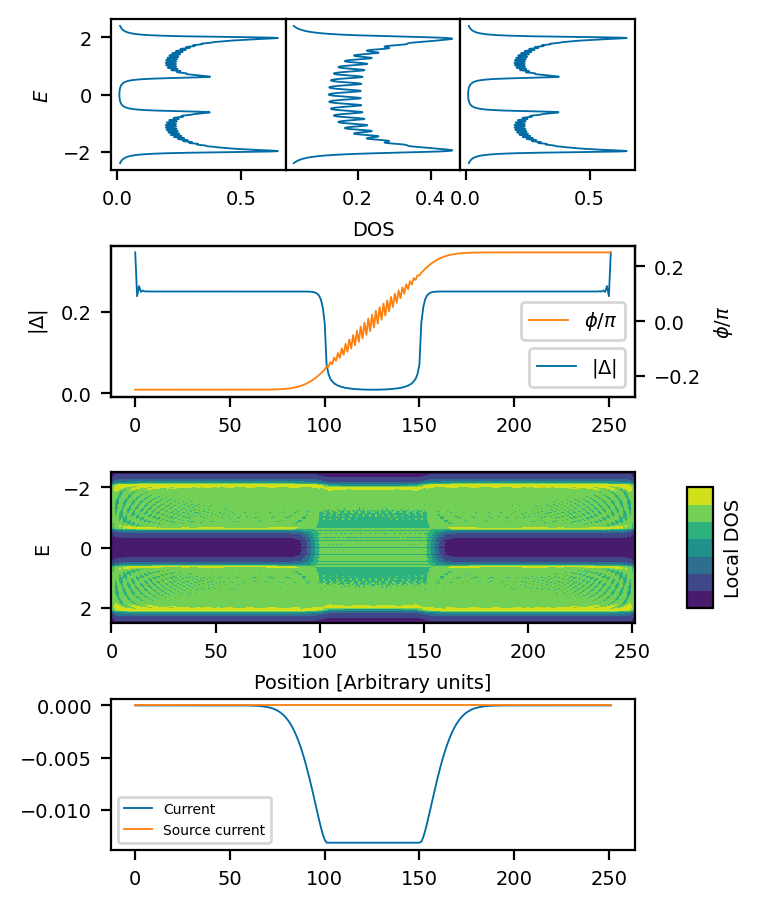

In [31]:
fig = plt.figure(figsize = (3.375,5.5), dpi = 200)

gs = fig.add_gridspec(4,3, wspace=0, hspace=0.5)

# fig, axes = plt.subplots(1, 3)
axl = fig.add_subplot(gs[0,0])
axc = fig.add_subplot(gs[0,1])
axr = fig.add_subplot(gs[0,2])
axb = fig.add_subplot(gs[1,:])
axLDOS = fig.add_subplot(gs[2,:])

DOS_S, eex = ModelS.get_DOS()
DOS_N, eex = ModelN.get_DOS()
axl.plot(DOS_S, eex)
axc.plot(DOS_N, eex)
axr.plot(DOS_S, eex)
ymax=np.max([(axl.get_ylim()), (axc.get_ylim()), (axr.get_ylim())])
ymin=np.min([(axl.get_ylim()), (axc.get_ylim()), (axr.get_ylim())])
ylim=(ymin, ymax)
axl.set_ylim(ylim)
axc.set_xlabel('DOS')
axl.set_ylabel('$E$')
axc.set_yticks([]), axr.set_yticks([])

axb.plot(np.abs(Del), label='|$\\Delta$|')
ax1=axb.twinx()
ax1.plot(np.angle(Del)/np.pi, 'C1', label='$\\phi/\\pi$')
axb.legend(loc='lower right')
ax1.legend(loc='center right')
axb.set_ylabel('|$\\Delta$|')
ax1.set_ylabel('$\\phi/\\pi$')


LDOS, eex = Model.get_LDOS(gam=0.01)

cplot = axLDOS.contourf(np.arange(Model.LL),eex,np.log(LDOS.T))
axLDOS.set_xlabel("Position [Arbitrary units]")
axLDOS.set_ylabel("E")
axLDOS.invert_yaxis()
axcb = axLDOS.inset_axes((1.1,0.1,0.05,0.8))
cb = fig.colorbar(cplot, cax=axcb)
cb.set_ticks([])
cb.set_label('Local DOS')


#####################

axcurrent = fig.add_subplot(gs[3,:])

current = np.zeros(Model.LL, dtype='complex')
for vvec in Model.vvecs.T:
    # current+=4*np.array(Model.ts)*(np.roll(vvec, 1)*(vvec.conjugate()) - vvec*np.roll(vvec.conjugate(),1))
    current+=-1.j*np.array(Model.ts)*(np.roll(vvec, 1)*(vvec.conjugate()) - np.roll(vvec, -1)*(vvec.conjugate()))
    current+=-1.j*np.array(Model.ts)*(np.roll(vvec, 1)*(vvec.conjugate()) - (np.roll(vvec,1)*(vvec.conjugate())).conjugate() )

source_current = np.zeros(Model.LL, dtype='complex')
for uvec, vvec in zip(Model.uvecs.T, Model.vvecs.T):
    source_current+=4.j*np.cumsum((np.array(Model.vs))*(np.array(Model.Delta)*(uvec.conjugate()*vvec)))
    
axcurrent.plot(current, label='Current')
axcurrent.plot(source_current.real, label='Source current')
axcurrent.legend(fontsize=5)

plt.savefig('BCS-N-BCS.pdf', bbox_inches='tight')

In [174]:
current = np.zeros(Model.LL, dtype='complex')
current2 = np.zeros(Model.LL, dtype='complex')
for vvec in Model.vvecs.T:
    # current+=4*np.array(Model.ts)*(np.roll(vvec, 1)*(vvec.conjugate()) - vvec*np.roll(vvec.conjugate(),1))
    current+=-1.j*np.array(Model.ts)*(np.roll(vvec, 1)*(vvec.conjugate()) - (np.roll(vvec,1)*(vvec.conjugate())).conjugate() )
    current2+=2*np.array(Model.ts)*(np.roll(vvec, 1)*(vvec.conjugate())).imag
    

/Users/user/opt/anaconda3/envs/UHH1/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


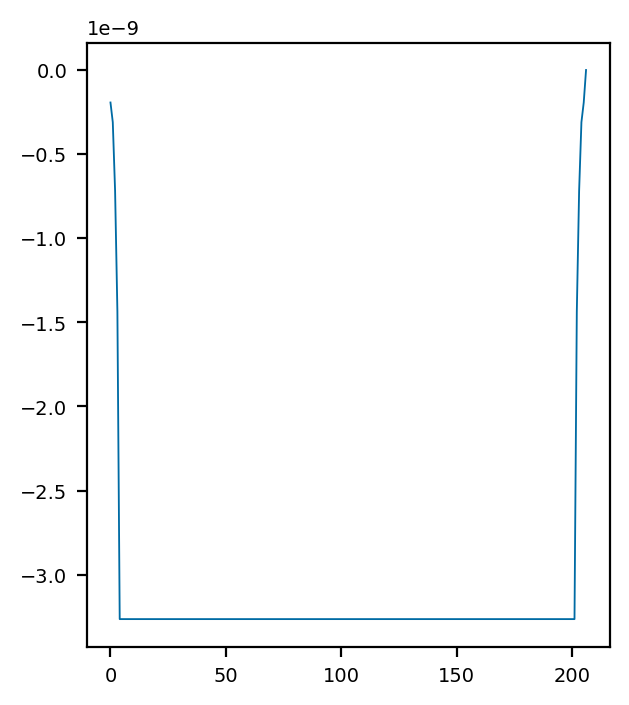

In [26]:
plt.plot(source_current)

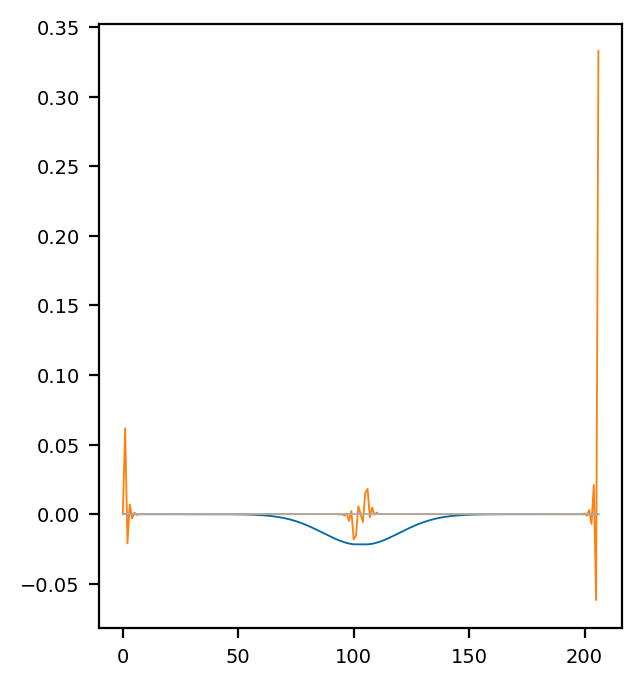

In [29]:
plt.plot(current.real)
plt.plot(current.imag)
# plt.plot(current2.real)
# plt.plot(-current2.imag)

# plt.plot(current.real)
plt.plot(source_current.real)

# plt.show() 
# plt.plot(current.imag, 'C0--')
# plt.plot(source_current.imag, 'C1--')


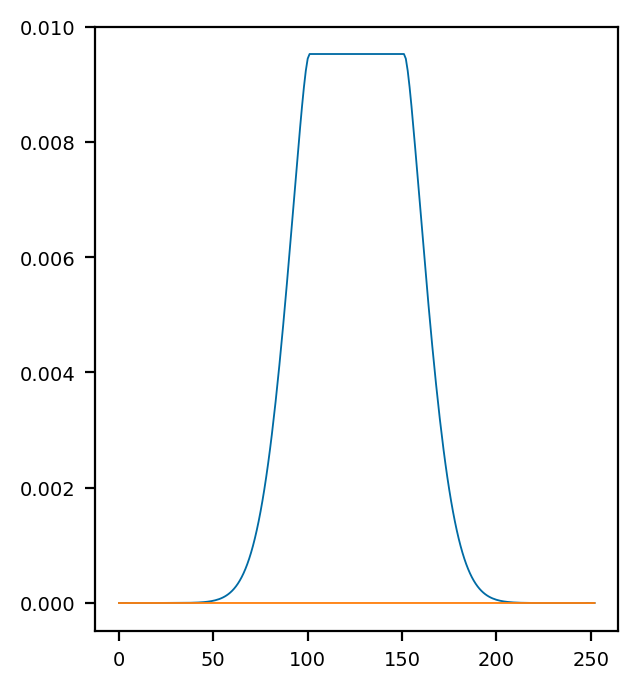

In [75]:
plt.plot((np.exp(-1j*np.pi/2)*current).imag)
plt.plot(source_current.imag)

In [392]:
Model.uvecs[0]

array([ 2.99662792e-13+0.j,  1.37645921e-12+0.j, -1.16294579e-03-0.j,
       -3.44670197e-03-0.j,  1.58139265e-02+0.j, -1.70227445e-02-0.j,
       -1.48098493e-02-0.j,  1.90060880e-02+0.j, -2.82140986e-02-0.j,
        3.18093371e-02+0.j, -2.27866505e-02-0.j, -3.02714208e-02-0.j,
        3.62799841e-02+0.j, -4.30921303e-02-0.j, -2.96501035e-02-0.j,
       -4.10337268e-02-0.j,  4.10025861e-02+0.j,  5.18153934e-02+0.j,
        3.65105717e-02+0.j,  5.25523043e-02+0.j, -4.28380467e-02-0.j,
        5.94211100e-02+0.j, -4.18836075e-02-0.j,  6.44920992e-02+0.j,
        4.06717643e-02+0.j, -6.61557258e-02-0.j, -4.53836147e-02-0.j,
        7.52969778e-02+0.j,  3.49836141e-02+0.j, -7.19470118e-02-0.j,
       -4.72434039e-02-0.j,  8.24964772e-02+0.j, -3.13076016e-02-0.j,
       -7.67635759e-02-0.j, -4.78468380e-02-0.j,  8.56423373e-02+0.j,
       -3.38708572e-02-0.j, -8.06138622e-02-0.j, -4.75962675e-02-0.j,
        8.63180135e-02+0.j, -3.92675001e-02-0.j, -8.35350255e-02-0.j,
       -4.68557295e-

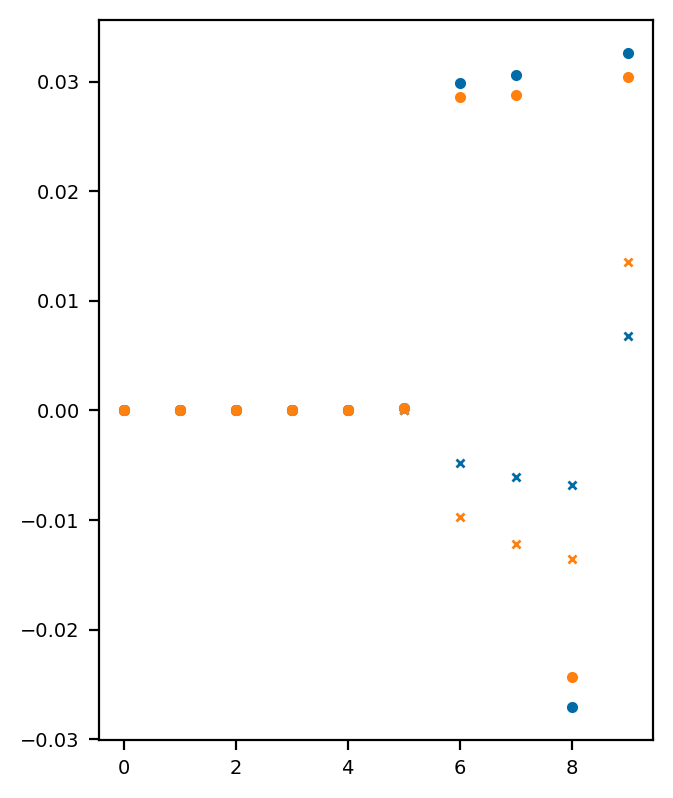

In [317]:
plt.plot(Model.uvecs[10,:10].real, "C0o")
plt.plot(Model.uvecs[10,:10].imag, "C0x")
plt.plot(Model.vvecs[10,:10].real, "C1o")
plt.plot(Model.vvecs[10,:10].imag, "C1x")

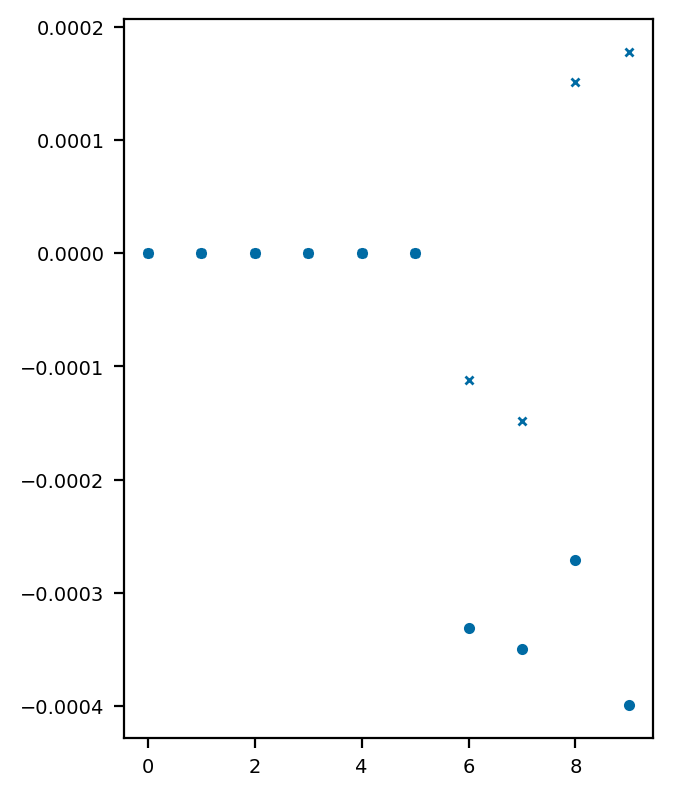

In [326]:
plt.plot((Model.uvecs[0,:10]*Model.vvecs.conjugate()[10,:10]).real, "C0o")
plt.plot((Model.uvecs[0,:10]*Model.vvecs.conjugate()[10,:10]).imag, "C0x")
# plt.plot(Model.uvecs[-1,:10]*Model.vvecs.conjugate()[10,:10], "C1o")

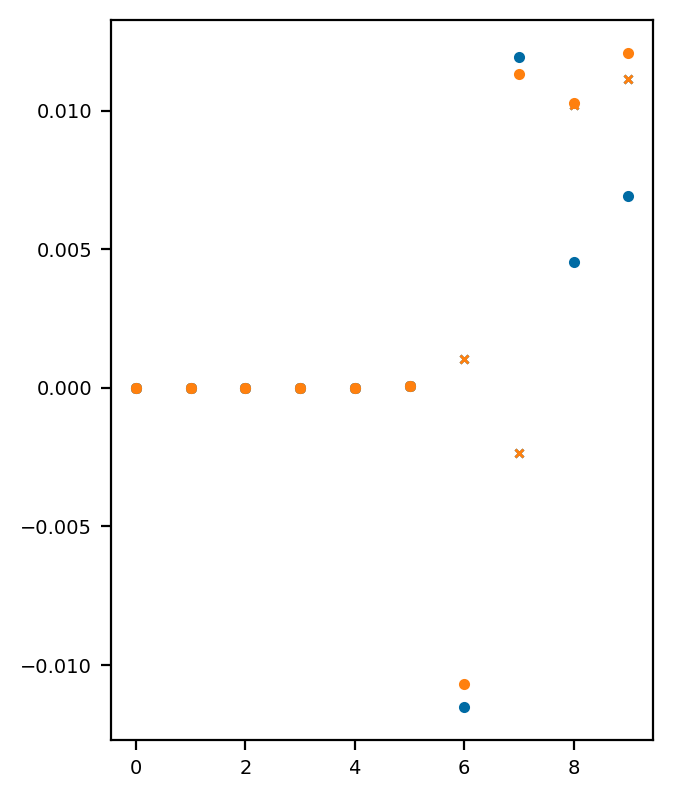

In [311]:
plt.plot(Model.uvecs[-1,:10].real, "C0o")
plt.plot(Model.uvecs[-1,:10].imag, "C0x")
plt.plot(Model.vvecs[-1,:10].real, "C1o")
plt.plot(Model.uvecs[-1,:10].imag, "C1x")

## BCS-N-BCS or BEC-N-BEC

In [27]:
LL = 210
N = 10

t = 1
v = -1.5
delphi = np.pi;
u0_S1 = -v/2
u0_S2 = u0_S1
u0_N = 0
mu_offset = 0

PBC = False

shape, ts, us, vs = TB1D(LL , t , v , [u0_S1 , u0_N, u0_S2] , N , mu_offset , PBC)

fix=5
def constrain_phase(Delta):
    Delta = Delta*np.exp(-1j*np.angle(Delta[0]))
    Delta[:fix]=np.abs(Delta[:fix])
    Delta[-fix:]=np.abs(Delta[-fix:])*np.exp(1j*delphi)
    return Delta

Model = TBmodel(LL, ts, us, vs , delphi, constrain_phase=constrain_phase)
Del , Pot, Evals , Uvecs , Vvecs , H , occu_raw , current , sourceCurr , H_ini = Model.iterate()  

[ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
u_0_N is  0
ts 

[ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

/Users/user/Documents/Science/BCS-BEC/D1_SSH_Core_lib.py:236: RuntimeWarning: divide by zero encountered in true_divide
  Energy_g2 = np.linalg.norm(np.abs(self.vs[0])*self.Delta)**2/np.abs([0])
/Users/user/Documents/Science/BCS-BEC/D1_SSH_Core_lib.py:175: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  DeltaF = np.array([abs(self.Delta.mean()), free_energy])


(0.35971115577319346+3.1614889157625736e-31j)
(0.35971115577319346+0j)
(0.30700043490959755-1.2680626262813523e-31j)
(0.30700043490959755+0j)
(0.2697277447981993+4.7277796340073376e-32j)
(0.2697277447981993+0j)
(0.24298388032765428+3.119223892228647e-30j)
(0.24298388032765428+0j)
(0.22335490913003944+6.0858118246973285e-28j)
(0.22335490913003944+0j)
(0.20866905683164702+2.4030263387814186e-26j)
(0.20866905683164702+0j)
(0.19751328469579443+3.535790072421796e-25j)
(0.19751328469579443+0j)
(0.18893623182335004+2.7710099249323884e-24j)
(0.18893623182335004+0j)
(0.18227785074256178+1.4248155120301388e-23j)
(0.18227785074256178+0j)
(0.17706868666965186+5.465768683297851e-23j)
(0.17706868666965186+0j)
(0.17296782249490833+1.699383979499496e-22j)
(0.17296782249490833+0j)
(0.16972326350034114+4.526442270181709e-22j)
(0.16972326350034114+0j)
(0.16714590210369945+1.0732059783270951e-21j)
(0.16714590210369945+0j)
(0.1650919807495948+2.327468967996531e-21j)
(0.1650919807495948+0j)
(0.1634510174842

In [28]:
constrain_phase

<function __main__.constrain_phase(Delta)>

In [29]:
# computing the source current:
Current_S = np.array([sum(sourceCurr[:x]) for x in range(LL)])

Text(0.5, 0, '$position$')

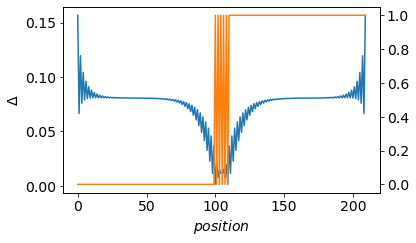

In [30]:
fig, ax = plt.subplots()
ax.plot(np.abs(Del))
ax2=ax.twinx()
ax2.plot(np.angle(Del)/np.pi, 'C1')
ax.set_ylabel('$\\Delta$')
ax.set_xlabel('$position$')
# ax.set_title('BCS-N-BCS LL=%d $N_{length}$=%d v=%.2f $\\mu_S$=%.2f $\\Delta\phi$=%.2f'% (LL,N,v,u0_S1,delphi),ha='center',fontsize=12)

In [16]:
(np.angle(Del[-1])-np.angle(Del[0]))/np.pi

0.9999999999976611

In [17]:
np.angle(Del[:5])

array([-3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265])

In [18]:
np.angle(Del[-5:])

array([-4.08071367e-12, -2.90217831e-12, -3.90840794e-12, -2.81645501e-12,
       -3.67388795e-12])

Text(0.5, 1.0, 'BCS-N-BCS LL=210 $N_{length}$=10 v=-1.50 $\\mu_S$=0.75 $\\Delta\\phi$=3.14')

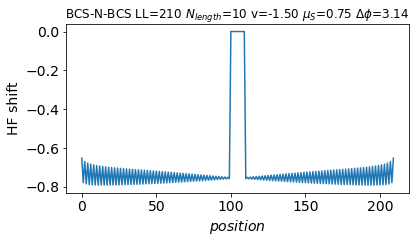

In [19]:
plt.figure()
plt.plot(Pot.real)
plt.ylabel('HF shift')
plt.xlabel('$position$')
plt.title('BCS-N-BCS LL=%d $N_{length}$=%d v=%.2f $\\mu_S$=%.2f $\\Delta\phi$=%.2f'% (LL,N,v,u0_S1,delphi),ha='center',fontsize=12)

The total current spatial average is:  8.610271036589895e-21


Text(0.5, 1.0, 'BCS-N-BCS LL=210 $N_{length}$=10 v=-1.50 $\\mu_S$=0.75 $\\Delta\\phi$=3.14')

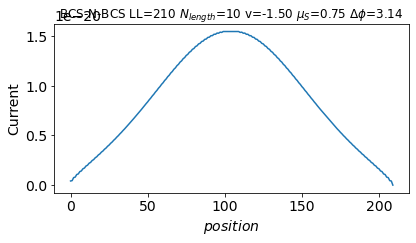

In [20]:
print('The total current spatial average is: ' , np.sum(np.real(current))/LL)
plt.figure()
plt.plot(np.real(current))
#plt.plot(np.imag(Current_S))
plt.ylabel('Current')
plt.xlabel('$position$')
plt.title('BCS-N-BCS LL=%d $N_{length}$=%d v=%.2f $\\mu_S$=%.2f $\\Delta\phi$=%.2f'% (LL,N,v,u0_S1,delphi),ha='center',fontsize=12)

u^2  0.00012548980152596025  v^2  0.9999999921261552
Energy is:  0.005121274134213483
u^2  0.9999999922933692  v^2  0.00012415015493373057
Energy is:  0.03678879072739649
u^2  0.00011146263676365592  v^2  0.9999999937880409
Energy is:  0.05113605939356325
u^2  0.9999999939465123  v^2  0.00011003170724337642
Energy is:  0.05736725527047182
u^2  0.00010685252871783304  v^2  0.9999999942912691
Energy is:  0.07863650062471161
u^2  0.9999999942804468  v^2  0.00010695376266517836
Energy is:  0.08169837966689553
u^2  0.00010530170591953355  v^2  0.9999999944557759
Energy is:  0.10704743964373176
u^2  0.9999999944538354  v^2  0.00010532012930588562
Energy is:  0.1090929658953701


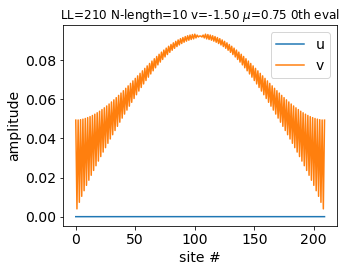

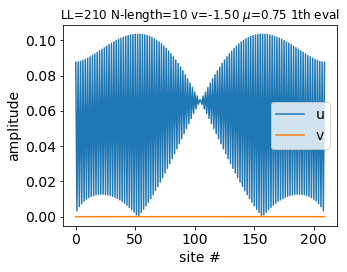

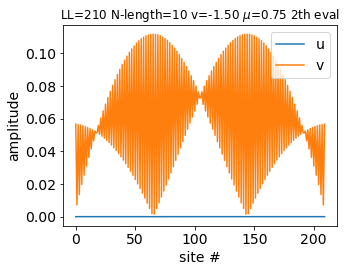

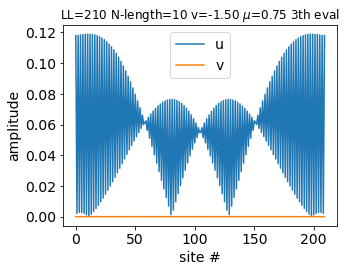

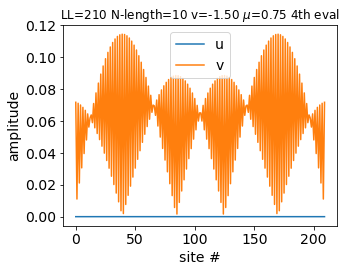

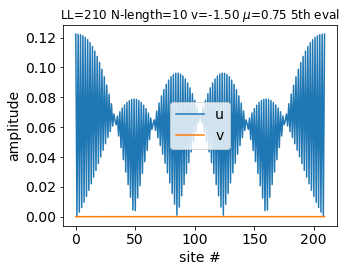

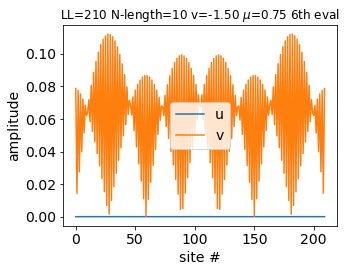

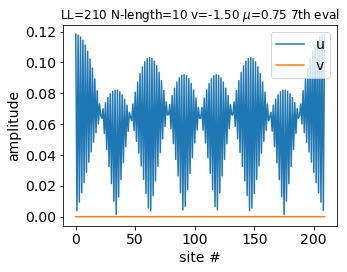

In [21]:
for i in range(0,len(Evals)):
    if abs(Evals[i])< 0.135:
        figure, axes = plt.subplots(1,1,figsize=(5,4))
        U= np.abs(Uvecs)[:,i];
        V = np.abs(Vvecs)[:,i];
        axes.plot(np.abs(Uvecs)[:,i],label='u')
        axes.plot(np.abs(Vvecs)[:,i],label='v')
        print('u^2 ' , np.sqrt(np.dot(U,U)) , ' v^2 ' , np.sqrt(np.dot(V,V)) )
        axes.legend()
    #     axes.set_ylim(-0.001,0.16)
        axes.legend()
        axes.set_title('LL=%d N-length=%d v=%.2f $\\mu$=%.2f %dth eval'% (LL,N,v,u0_S1,i),ha='center',fontsize=12)
        print('Energy is: ' ,  Evals[i])
        axes.set_xlabel('site #')
        axes.set_ylabel('amplitude')
#     plt.savefig('OBC-BCS-N-BCS-LL%d-N_length%d-v%.2f-u0%.2f-%dth-uv-abs.png' % (LL,N,v,u0,i))

104.99999999936779


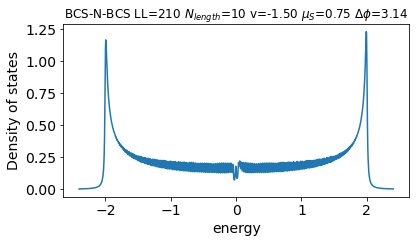

In [22]:
print(np.sum(occu_raw))
DOS, eex = Model.get_DOS(gam=0.01)

plt.figure()
plt.xlabel("energy")
plt.ylabel("Density of states")
plt.title('BCS-N-BCS LL=%d $N_{length}$=%d v=%.2f $\\mu_S$=%.2f $\\Delta\phi$=%.2f'% (LL,N,v,u0_S1,delphi),ha='center',fontsize=12)
plt.plot(eex, DOS)

In [23]:
Model.us

array([0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.

In [210]:
print('Uvecs')
for i in range(10):   
    print(np.max(np.abs(Uvecs)[:,i]))
print('Vvecs')
for i in range(10):    
    print(np.max(np.abs(Vvecs)[:,i]))    

Uvecs
0.28670493158223165
0.12074440896076315
0.12777942246478013
0.1203259117773816
0.08264476722556073
0.09267927607689143
0.08280503036816986
0.08696068291714884
0.08308876730812197
0.08557150135662063
Vvecs
0.0485119161595533
0.09673658706098186
0.10232621009431253
0.0966075915051883
0.07022529981989621
0.07795248023387841
0.06879306318262507
0.07054188643920203
0.0665637520925683
0.06611940405073002


In [211]:
LDOS, eex = Model.get_LDOS(gam=0.01)

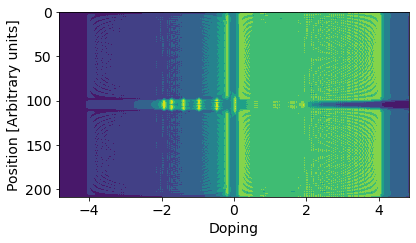

In [213]:
fig, ax = plt.subplots()
ax.contourf(eex,np.arange(LL),np.log(LDOS))
# ax.contourf(eex_h,np.arange(LL),DOSes_h)
ax.set_ylabel("Position [Arbitrary units]")
ax.set_xlabel("Doping")
# ax.set_title("Hole DOS")
ax.invert_yaxis()

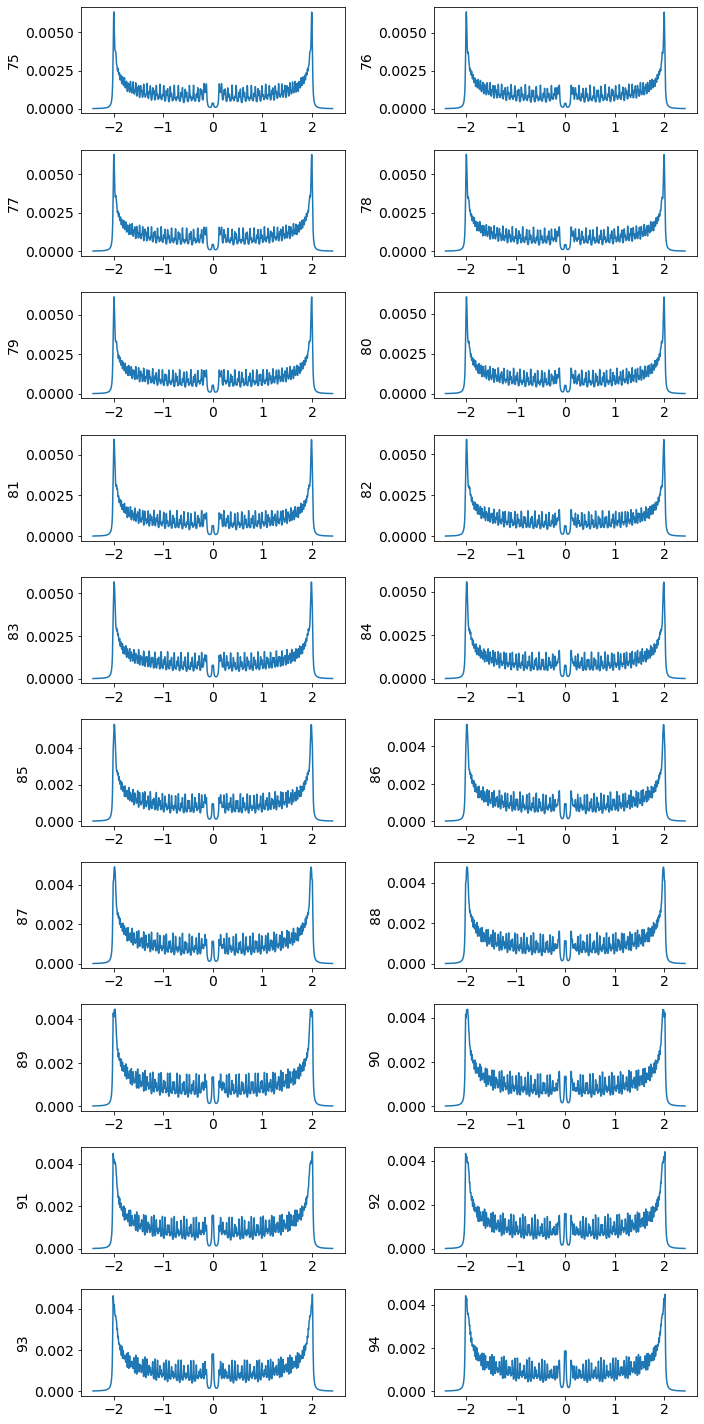

In [126]:
figure, axis = plt.subplots(10,2,figsize=(10,20))
for i in np.arange(10):
    for each in range(2):
        each_true = each + i *2+ 75
        #axis[i, each].set_xlabel("energy")
        axis[i,each].set_xticks(np.arange(-3, 3, step=1))
        axis[i, each].set_ylabel("%d" % each_true)
        axis[i, each].plot(eex, LDOS[each_true,:])
#axis[10,0].set_ylabel("%d" % 20)
#axis[10,0].plot(eex, LDOS[20,:])
#axis[10,1].set_ylabel("%d" % 20)
#axis[10,1].plot(eex, LDOS[20,:])
# figure.savefig('1D-SSH-open-20-ratio0.15-LDOS.png')

## BCS-N-BEC

[ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


<IPython.core.display.Javascript object>


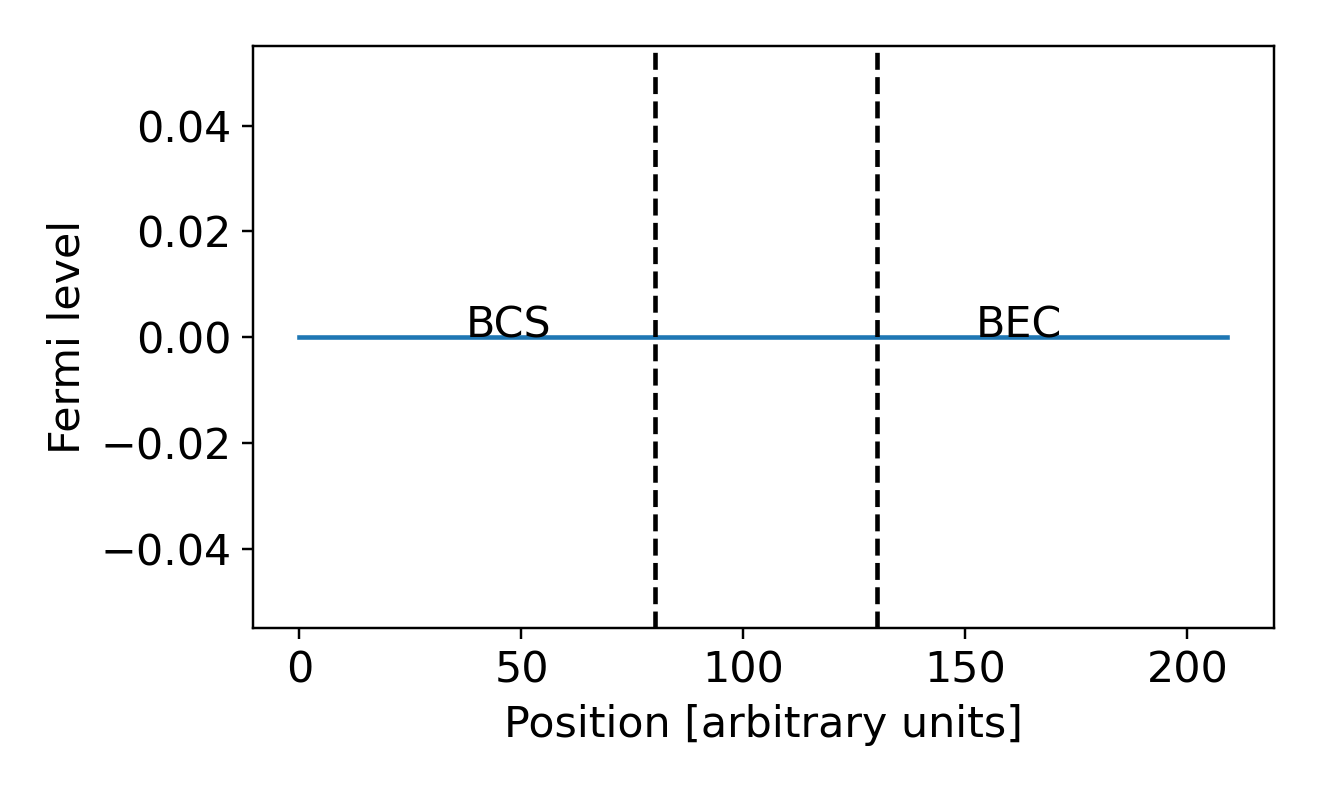

Convergence took 23 iterations
occu=113.5003


In [26]:
LL =210
N=50
t=1
v = 0.5
u0 = -1.0 # Diagonal shift
mu_offset = 0.0
PBC=False
# N_length=int(LL//2+LL/N)-int(LL//2-LL//N)
# print(N_length)
shape, ts, us, vs = TB1D(LL,t,v,u0,N,mu_offset, PBC)
Model = TBmodel(LL, ts, us, vs)
Del, Pot, Evals, Uvecs,Vvecs,H,occu_raw,H_ini = Model.iterate()
n=np.sum(occu_raw)
print('occu=%.4f' % n)

[ 1.43328562e-11  2.09820305e-11  2.20222621e-11  2.21454725e-11
  2.21579265e-11  2.21590883e-11  2.21591433e-11  2.21591314e-11
  2.21591511e-11  2.21592058e-11  2.21591851e-11  2.21591808e-11
  2.21591795e-11  2.21591819e-11  2.21591871e-11  2.21591849e-11
  2.21591675e-11  2.21591473e-11  2.21591873e-11  2.21591472e-11
  2.21591893e-11  2.21591515e-11  2.21591630e-11  2.21591684e-11
  2.21591764e-11  2.21592046e-11  2.21592108e-11  2.21592212e-11
  2.21590707e-11  2.21593575e-11  2.21589480e-11  2.21593154e-11
  2.21591623e-11  2.21590575e-11  2.21593278e-11  2.21591764e-11
  2.21592152e-11  2.21591025e-11  2.21591106e-11  2.21591899e-11
  2.21593535e-11  2.21592349e-11  2.21591625e-11  2.21589628e-11
  2.21594001e-11  2.21592418e-11  2.21591048e-11  2.21590878e-11
  2.21589961e-11  2.21593453e-11  2.21594113e-11  2.21589381e-11
  2.21591450e-11  2.21590629e-11  2.21590087e-11  2.21593019e-11
  2.21593063e-11  2.21594070e-11  2.21591545e-11  2.21592033e-11
  2.21591955e-11  2.21590

<IPython.core.display.Javascript object>


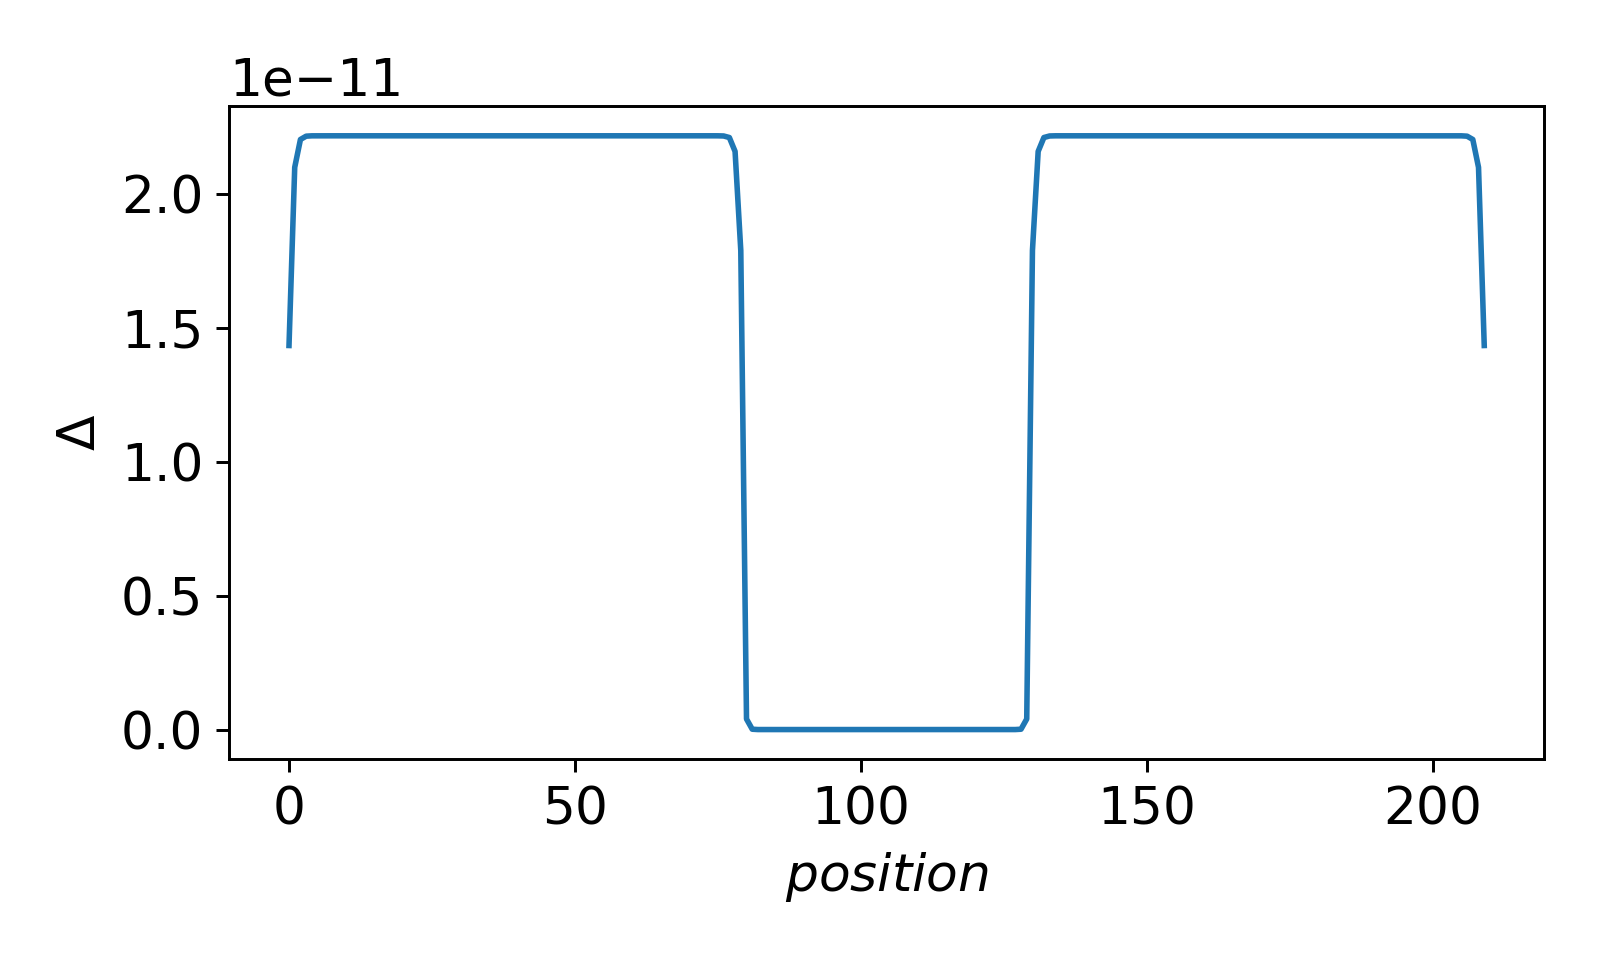

[0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.000

<IPython.core.display.Javascript object>


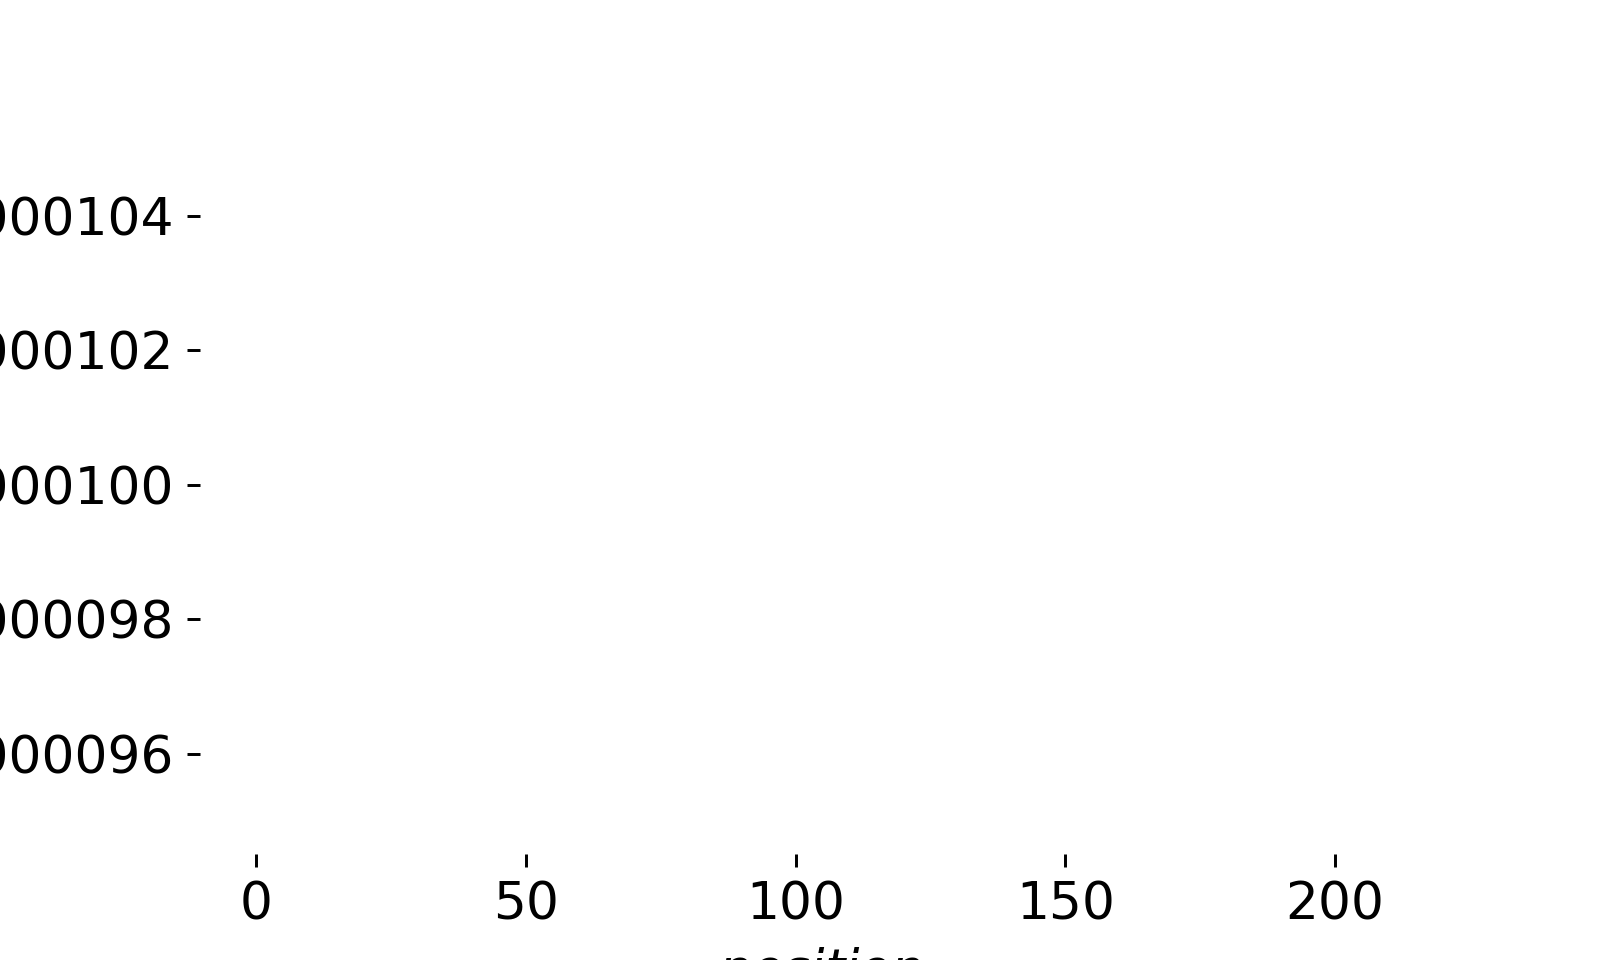

Text(0.5, 0, '$position$')

In [101]:
print(Del.real)
plt.figure()
plt.plot(Del.real)
plt.ylabel('$\\Delta$')
plt.xlabel('$position$')

print(Pot.real)
plt.figure()
plt.plot(Pot.real)
plt.ylabel('$\\HF Shift$')
plt.xlabel('$position$')

75.0


<IPython.core.display.Javascript object>


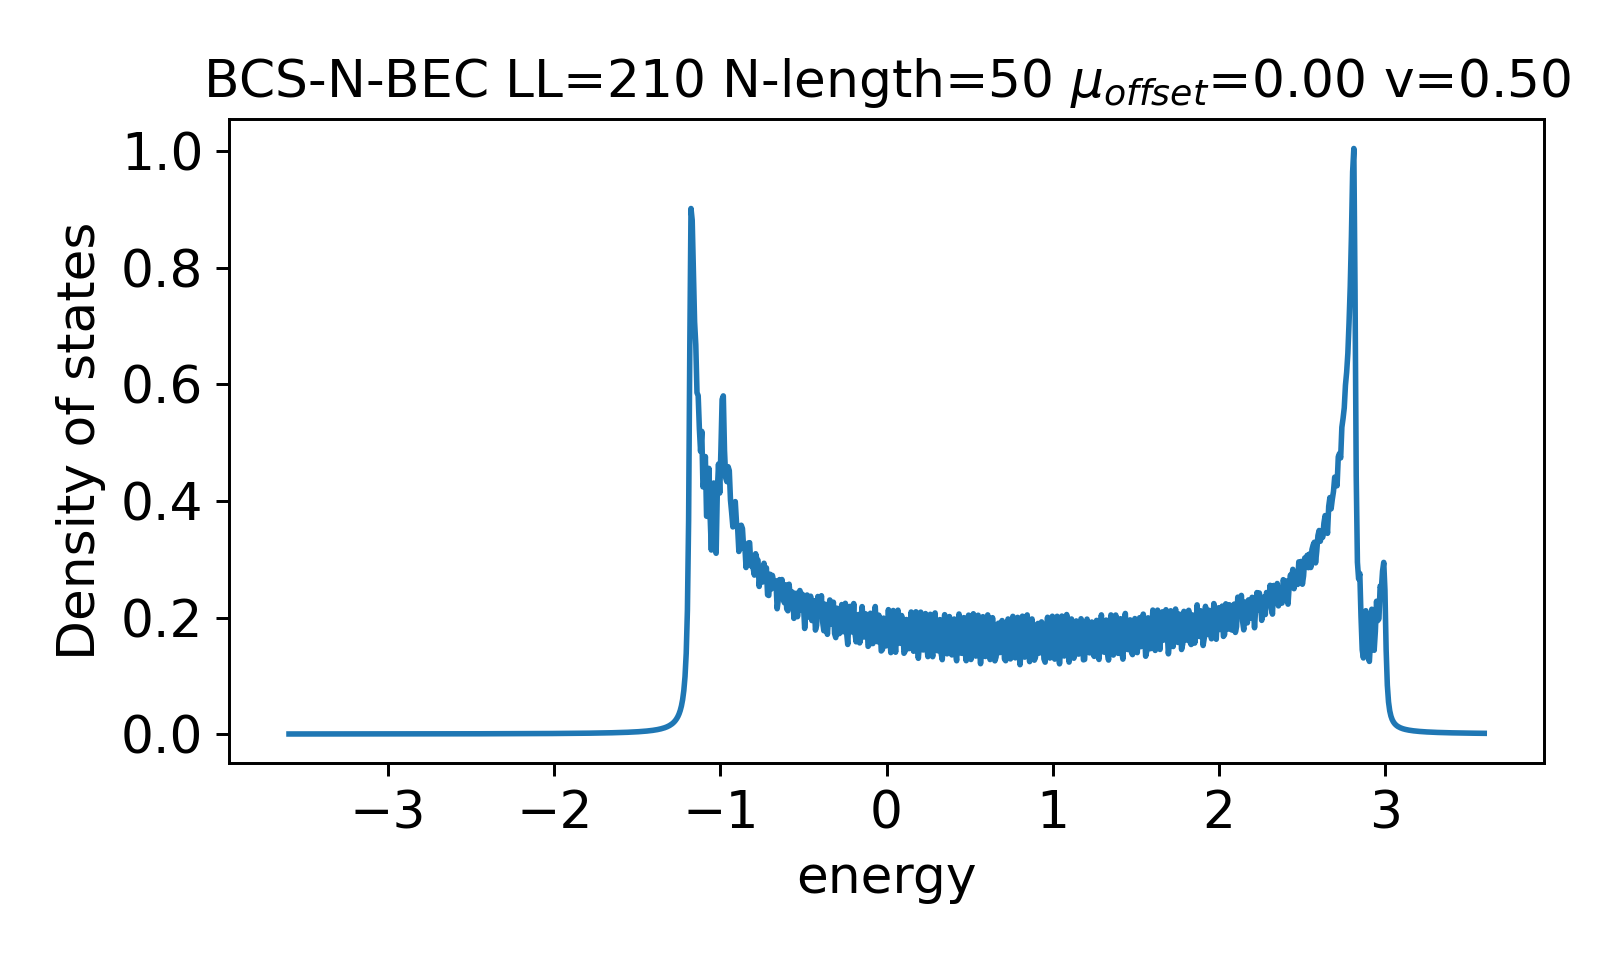

In [106]:
print(np.sum(occu_raw))
occu=np.sum(occu_raw)
DOS, eex = Model.get_DOS(gam=0.01)
#LDOS,eex,uvecshape,uvecplusshape= Model.get_LDOS(gam=0.01)
#out_put = [[eex[i],DOS[i]] for i in range(len(DOS))]
#print('out_put',out_put)
plt.figure()
plt.xlabel("energy")
plt.ylabel("Density of states")
# plt.xlim(-0.5,0.5)
plt.title('BCS-N-BEC LL=%d N-length=%d $\mu_{offset}$=%.2f v=%.2f'% (LL,N,mu_offset,v),ha='center',fontsize=14)
plt.plot(eex, DOS)

In [107]:
print(np.max(DOS))
print(DOS[499:501])
print(eex[499:501])

1.004804884732575
[0.15134501 0.16644955]
[-0.00359977  0.00359977]


In [30]:
print(Evals[:20])

[0.02990143 0.08264102 0.14359121 0.19186155 0.25535268 0.28439404
 0.29062167 0.29223327 0.29847083 0.30770979 0.31818191 0.32974006
 0.33598268 0.34223209 0.34891099 0.35415624 0.35527406 0.36445213
 0.36935265 0.37673665]


In [110]:
LDOS, eex = Model.get_LDOS(gam=0.01)
print(np.max(eex))
print(np.min(eex))


3.596174025665161
-3.596174025665161


<IPython.core.display.Javascript object>


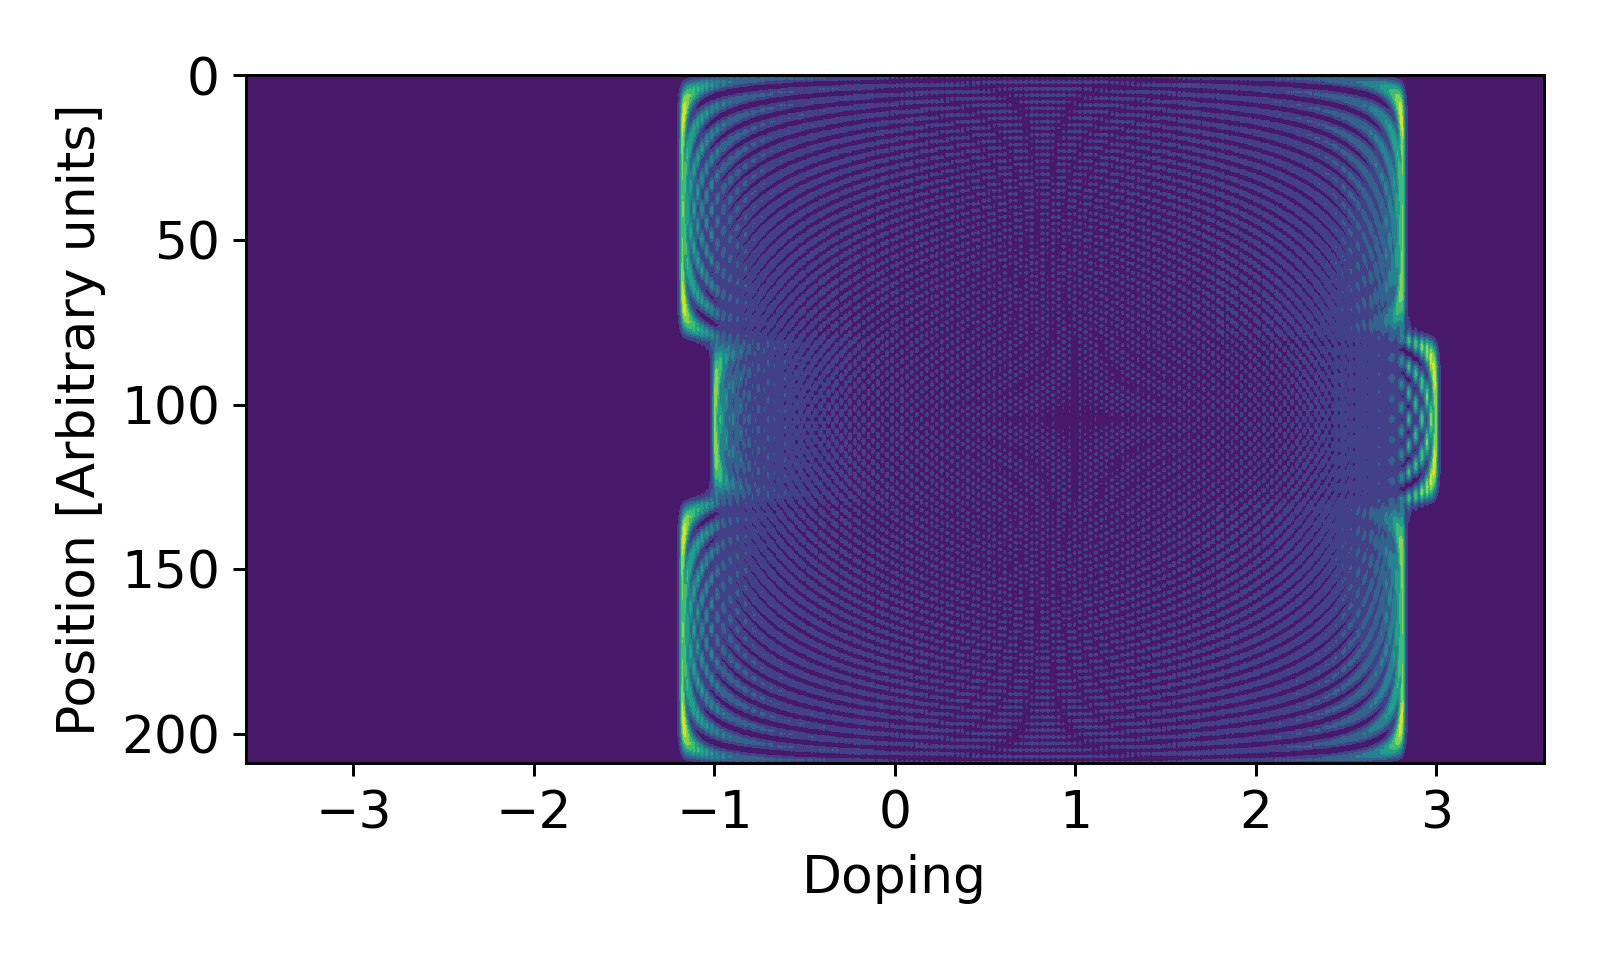

<IPython.core.display.Javascript object>


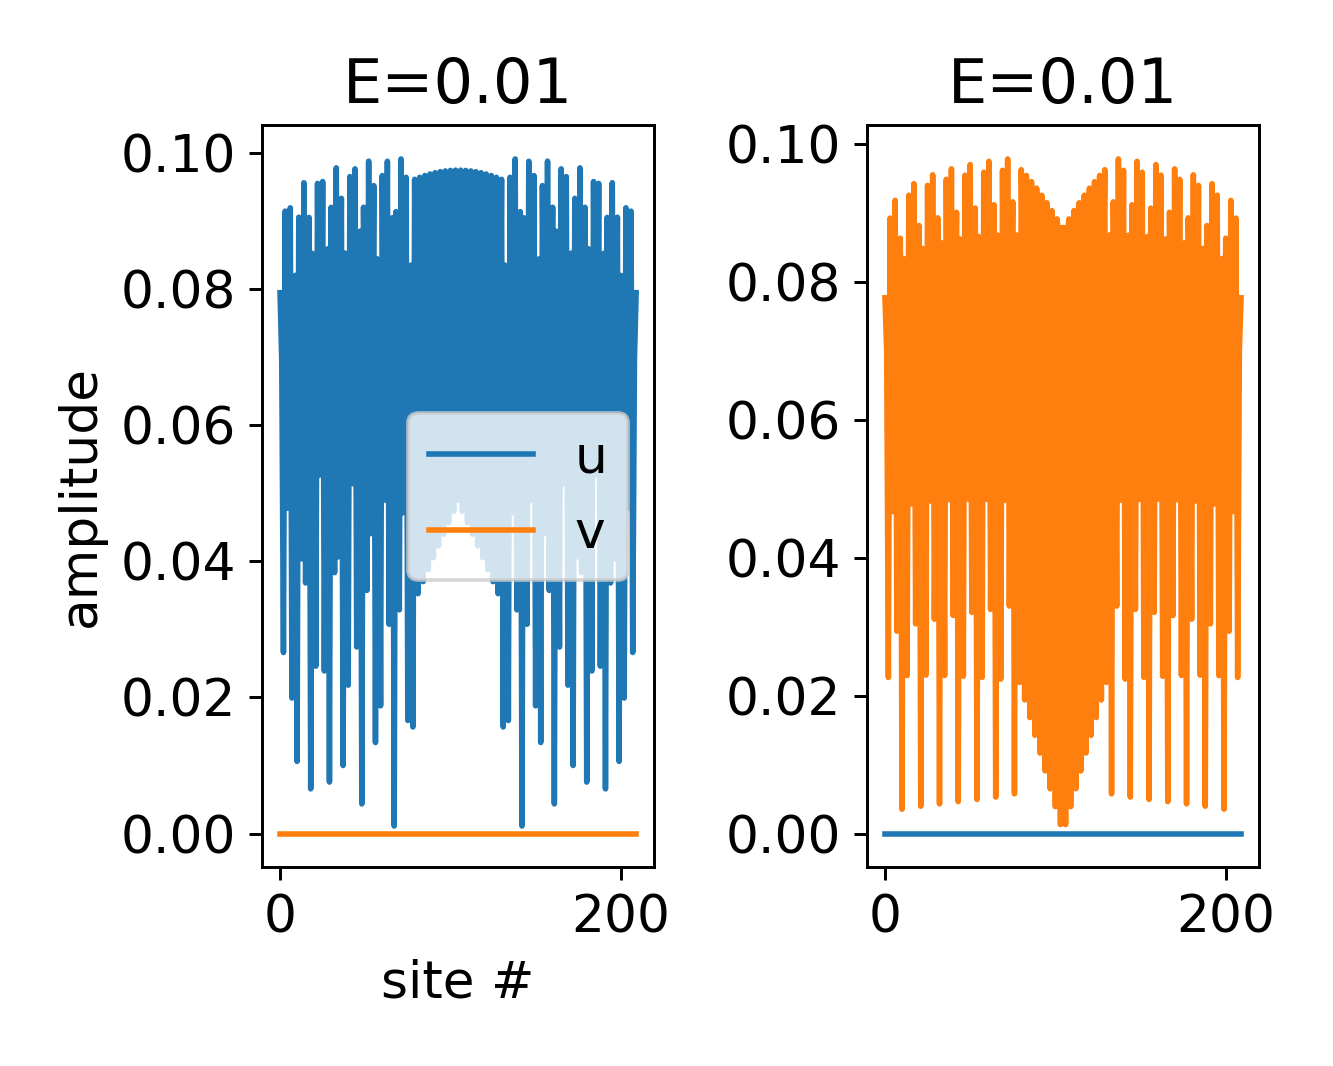

<IPython.core.display.Javascript object>


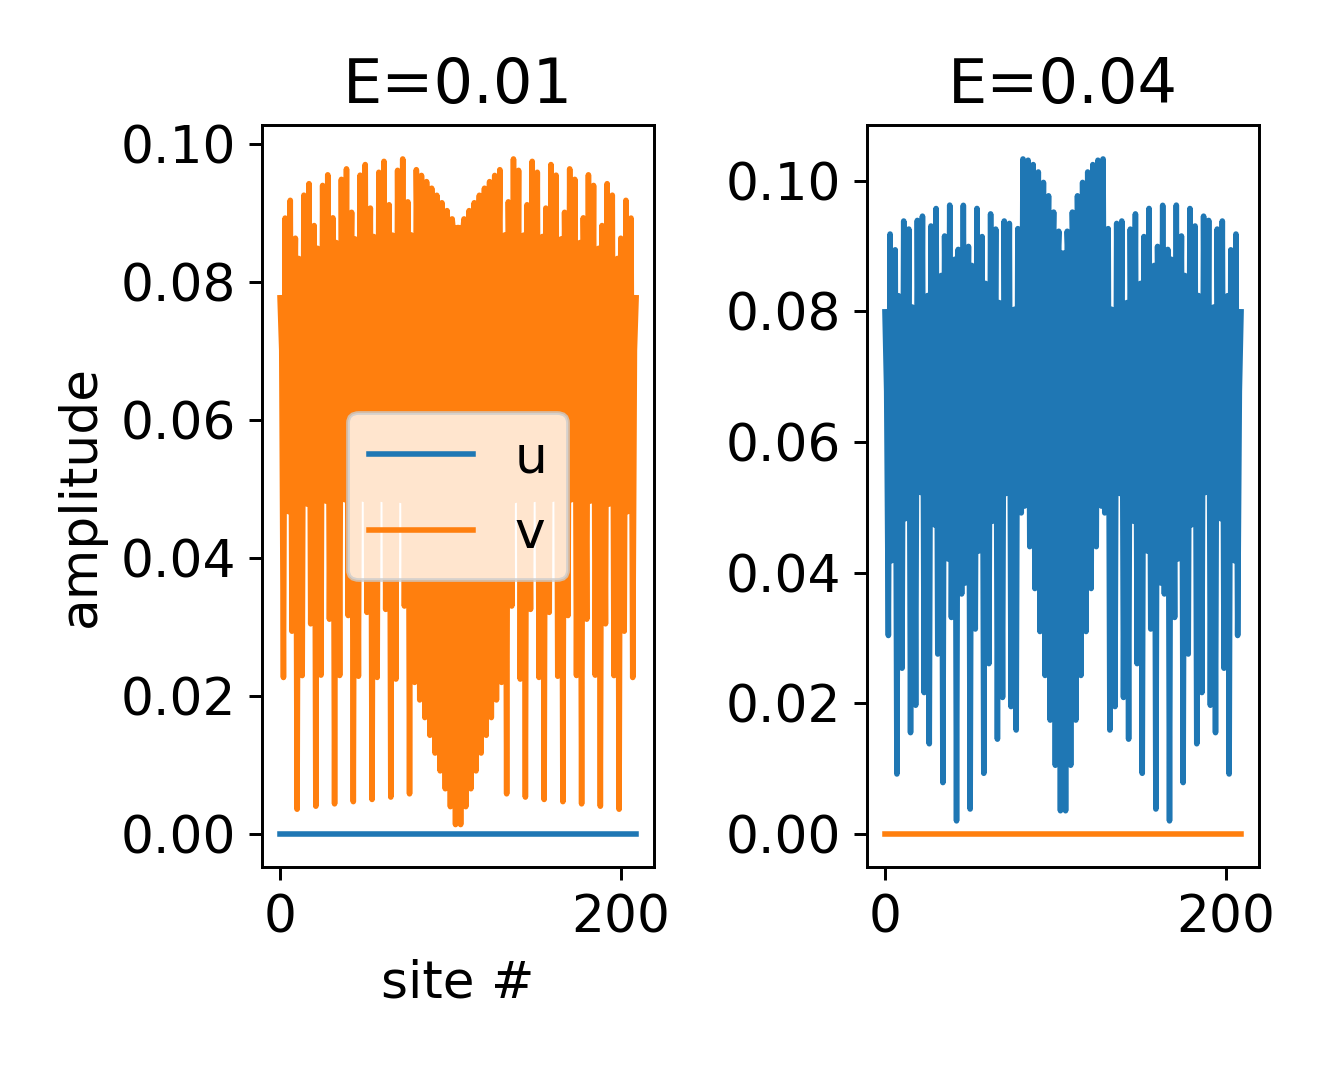

<IPython.core.display.Javascript object>


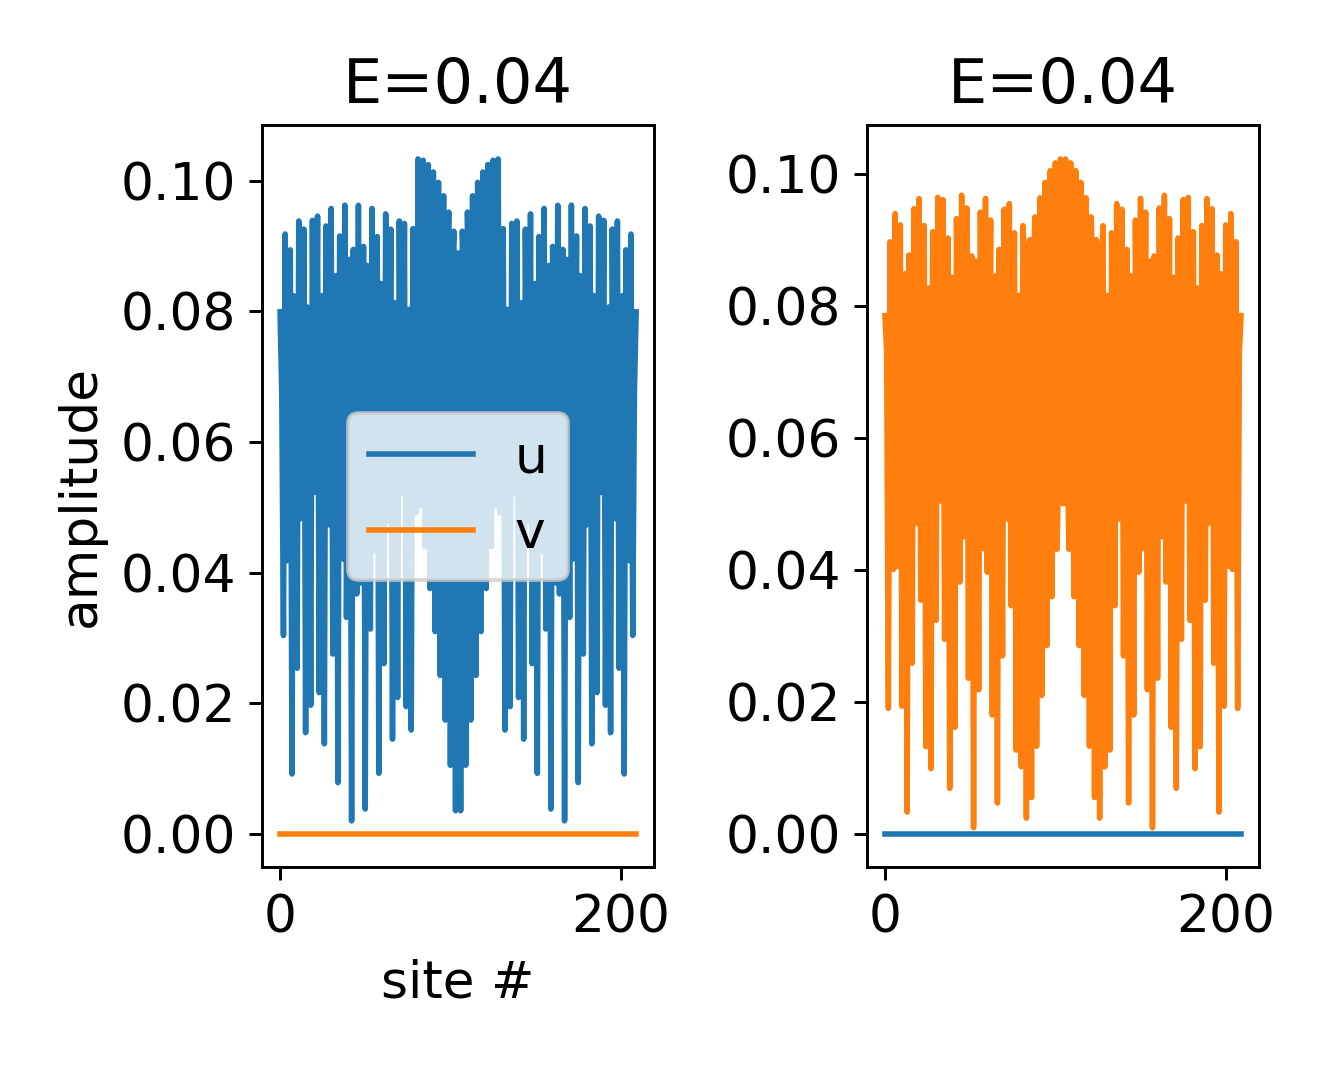

<IPython.core.display.Javascript object>


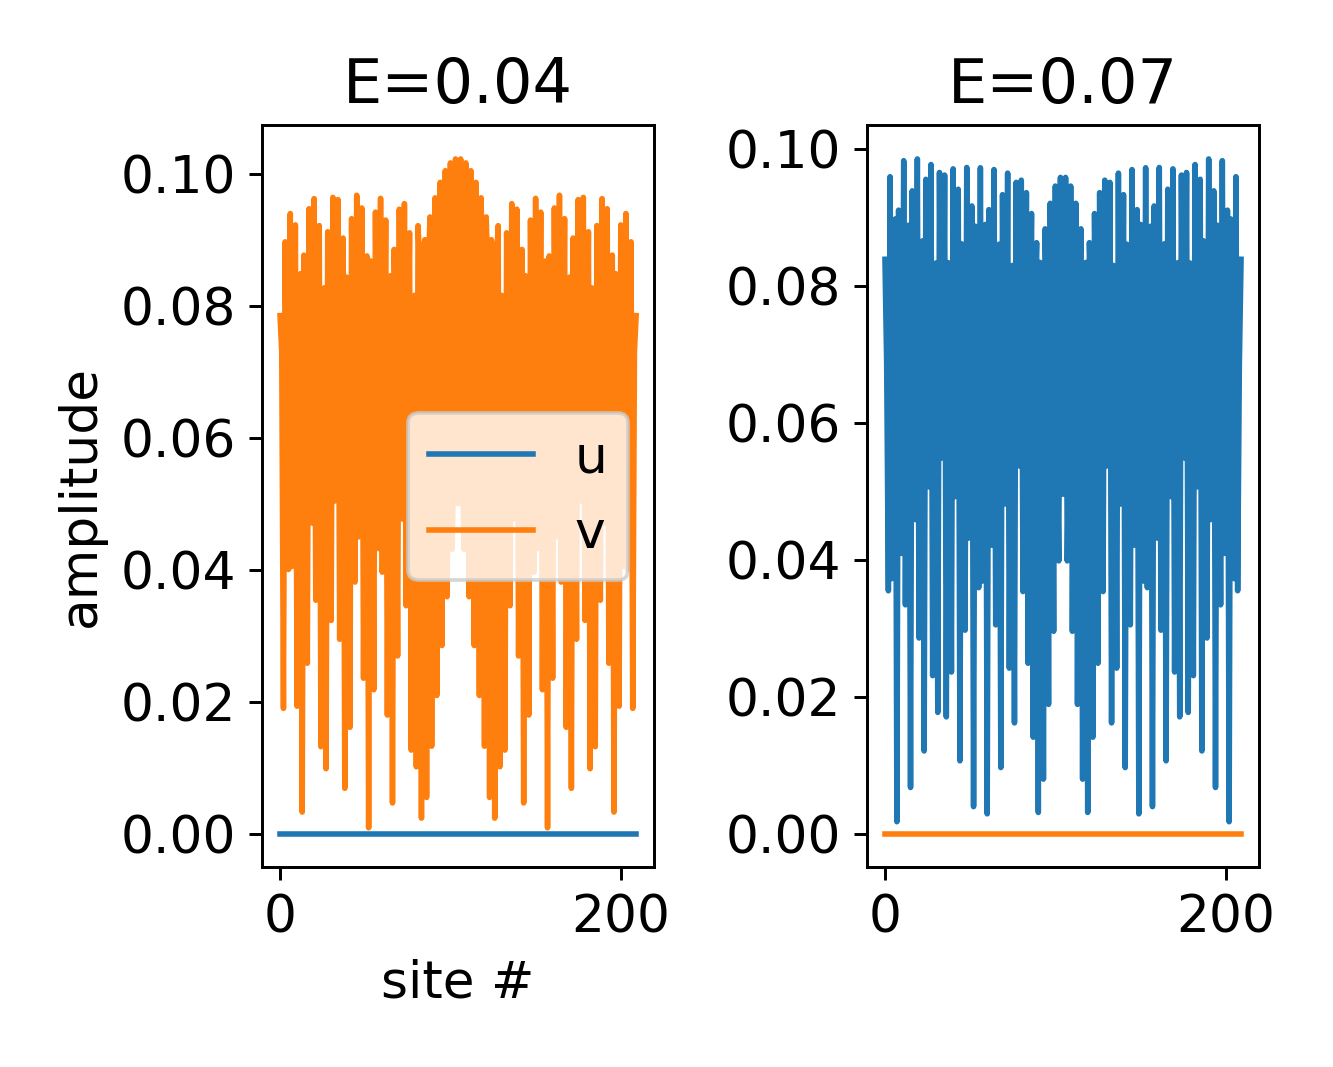

<IPython.core.display.Javascript object>


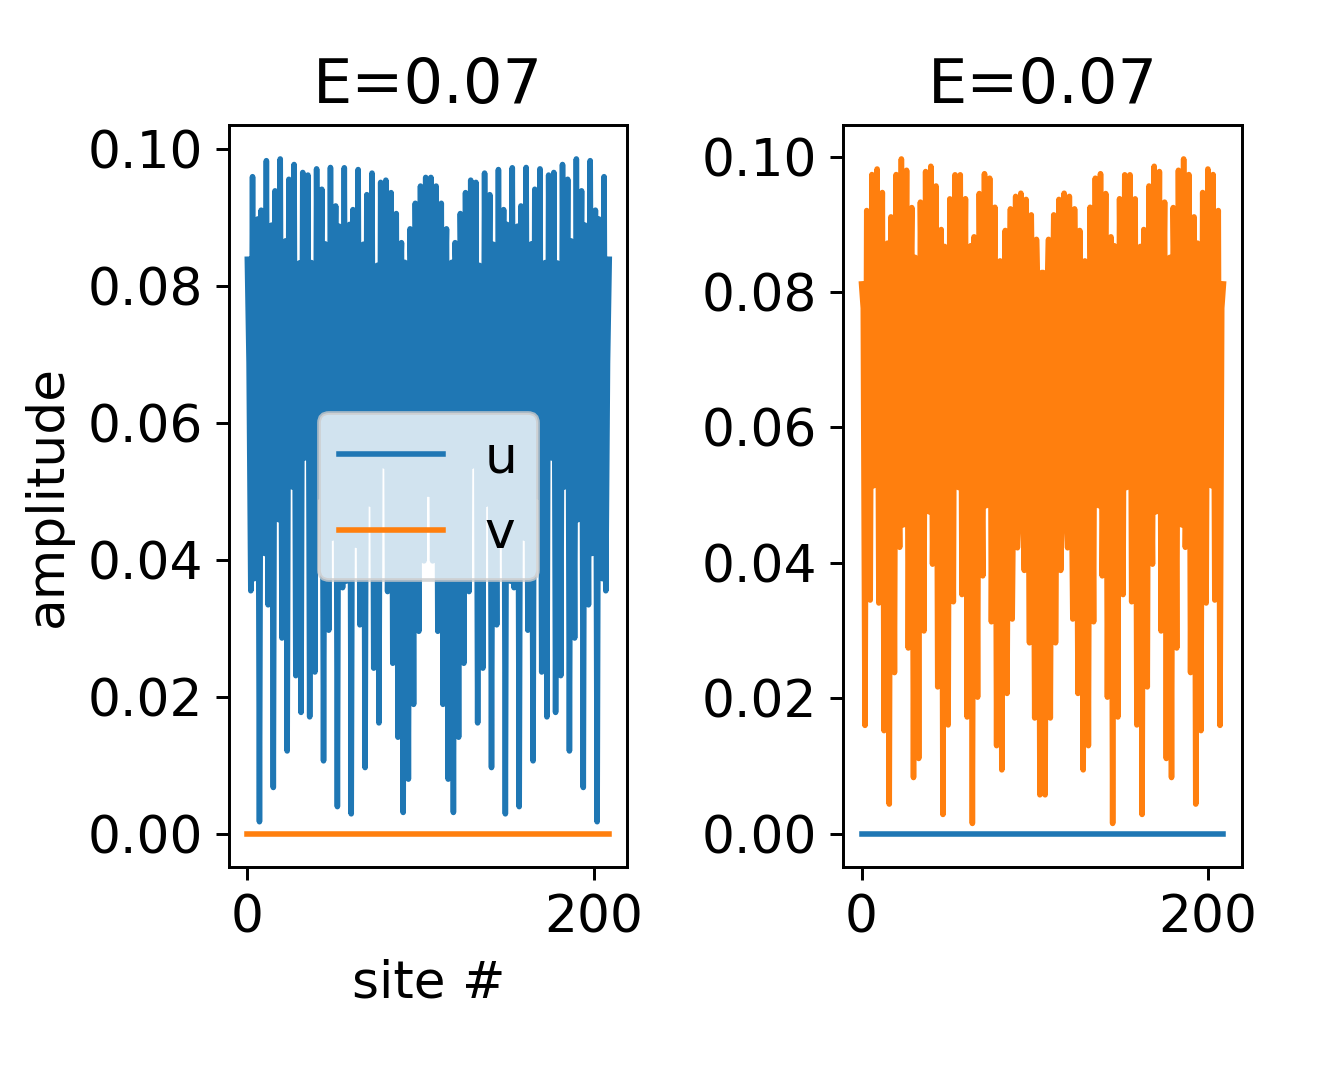

In [111]:
fig, ax = plt.subplots()
ax.contourf(eex,np.arange(LL),LDOS)
# ax.contourf(eex_h,np.arange(LL),DOSes_h)
ax.set_ylabel("Position [Arbitrary units]")
ax.set_xlabel("Doping")
# ax.set_title("Hole DOS")
ax.invert_yaxis()


for i in range(0,5):
    figure, axes = plt.subplots(1,2,figsize=(5,4))
    axes[0].plot(np.abs(Uvecs)[:,i],label='u')
    axes[0].plot(np.abs(Vvecs)[:,i],label='v')
    axes[1].plot(np.abs(Uvecs)[:,i+1],label='u')
    axes[1].plot(np.abs(Vvecs)[:,i+1],label='v')
    #axes.legend()
#     axes.set_ylim(-0.001,0.16)
    axes[0].legend()
    axes[0].set_title("E={:.2f}".format(Evals[i]))
    axes[1].set_title("E={:.2f}".format(Evals[i+1]))
    axes[0].set_xlabel('site #')
    axes[0].set_ylabel('amplitude')

<IPython.core.display.Javascript object>


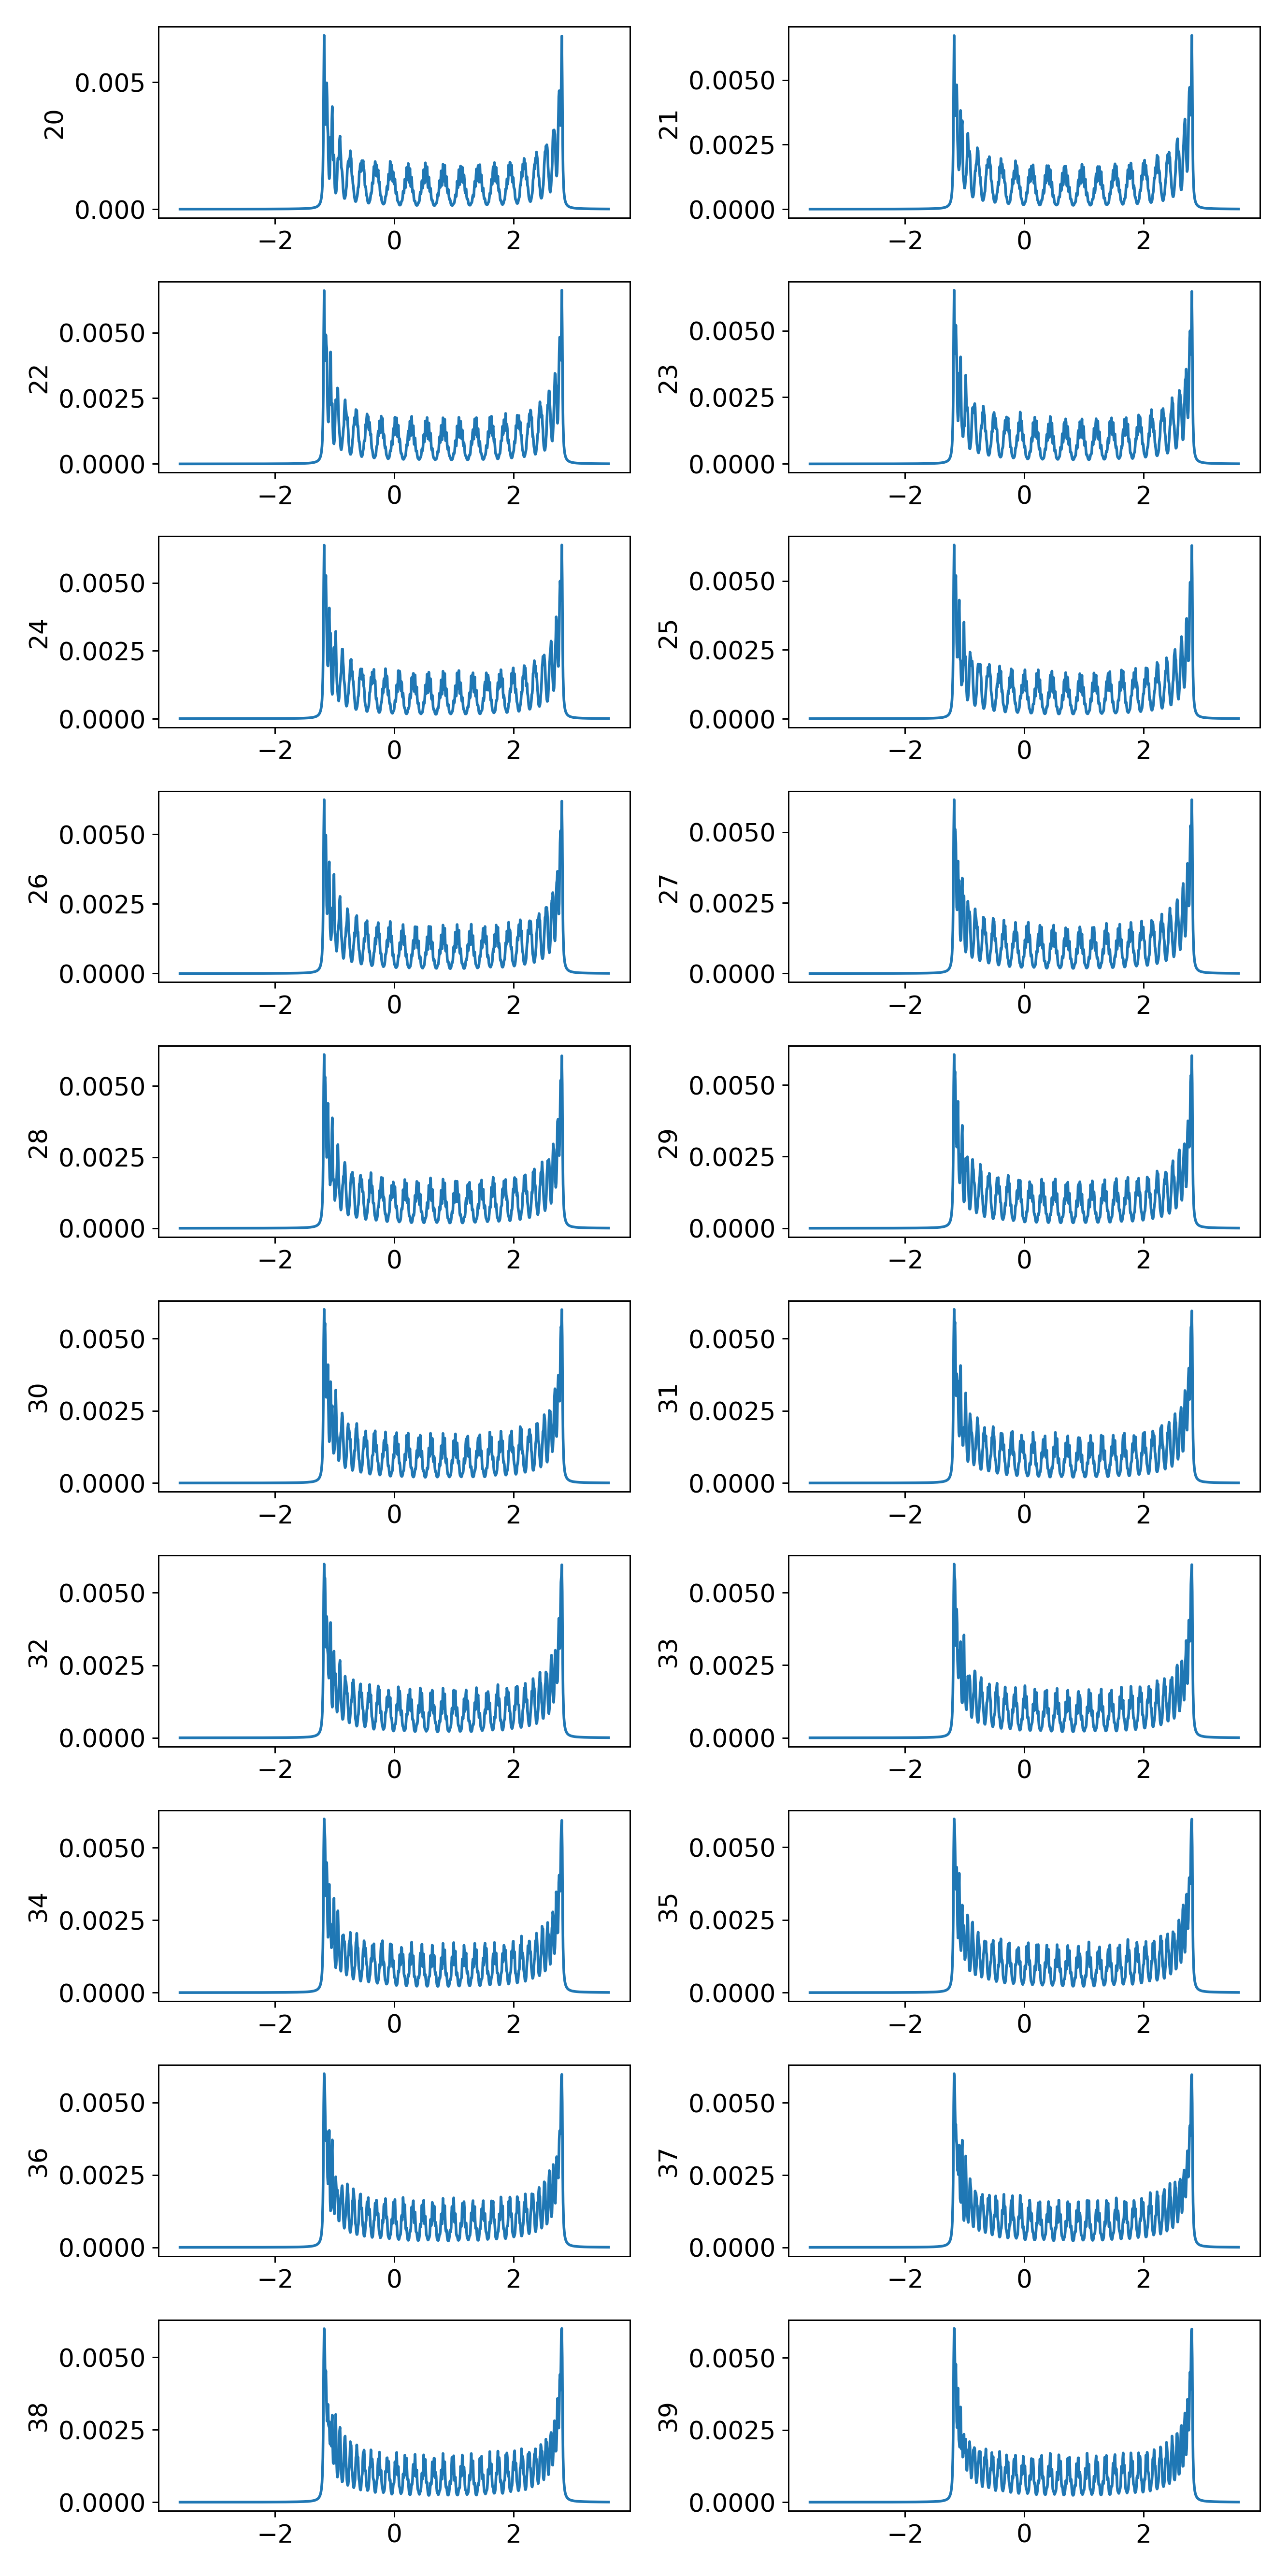

In [112]:
figure, axis = plt.subplots(10,2,figsize=(10,20))
for i in np.arange(10):
    for each in range(2):
        each_true = each + i *2 + 20
        #axis[i, each].set_xlabel("energy")
#         axis[i,each].set_xticks(np.arange(-3, 3, step=1))
        axis[i, each].set_ylabel("%d" % each_true)
        axis[i, each].plot(eex, LDOS[each_true,:])

<IPython.core.display.Javascript object>


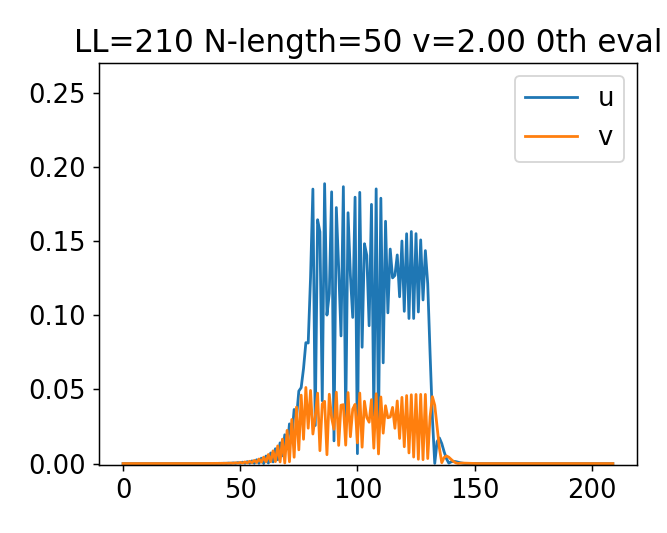

<IPython.core.display.Javascript object>


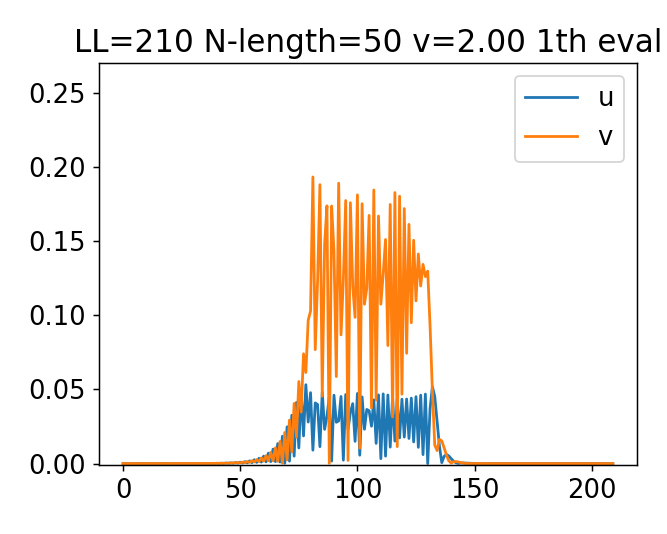

<IPython.core.display.Javascript object>


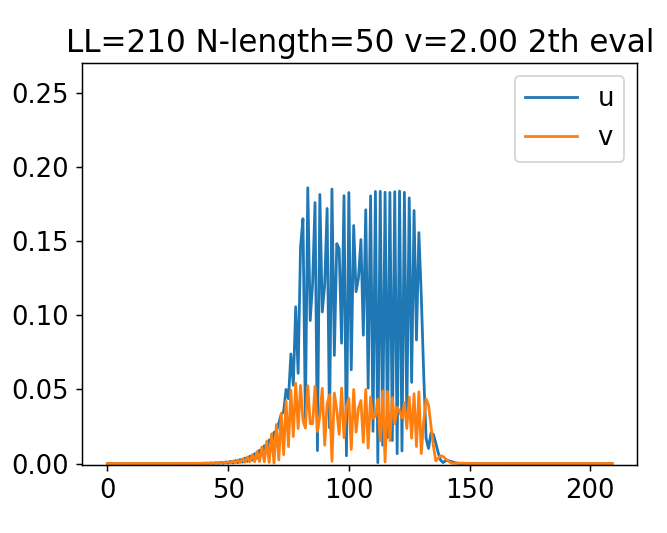

<IPython.core.display.Javascript object>


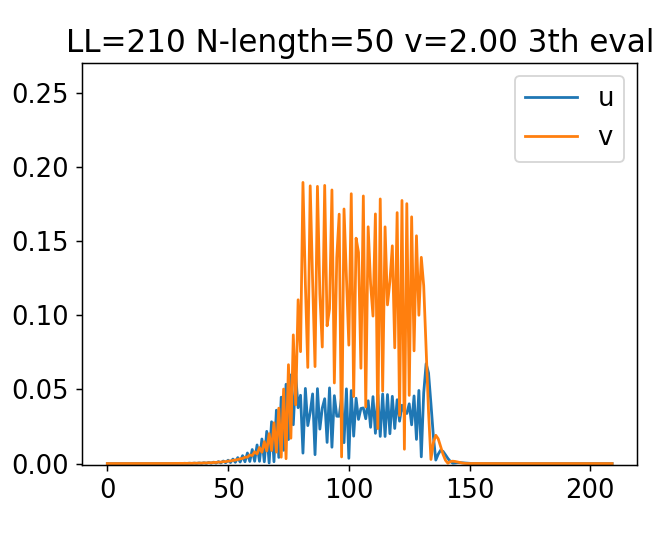

<IPython.core.display.Javascript object>


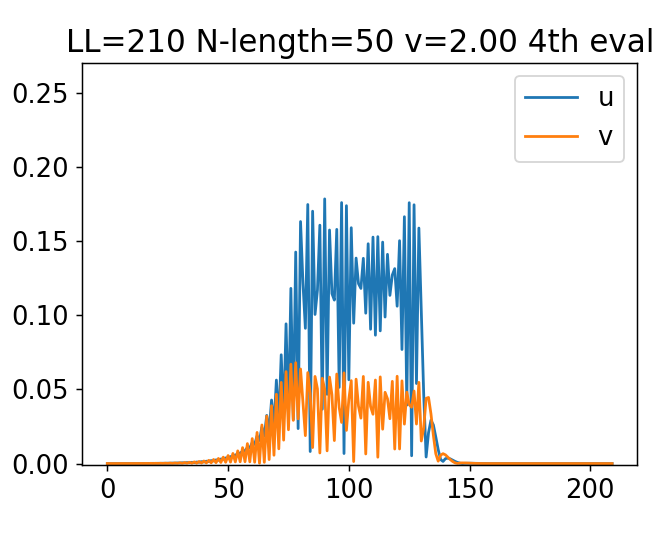

<IPython.core.display.Javascript object>


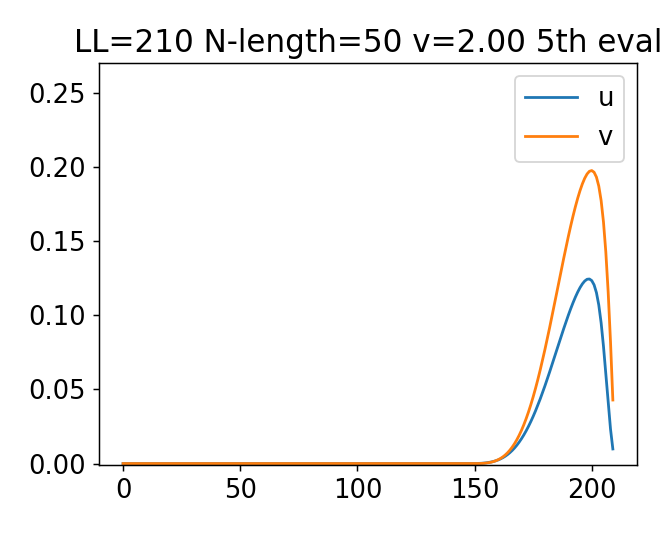

<IPython.core.display.Javascript object>


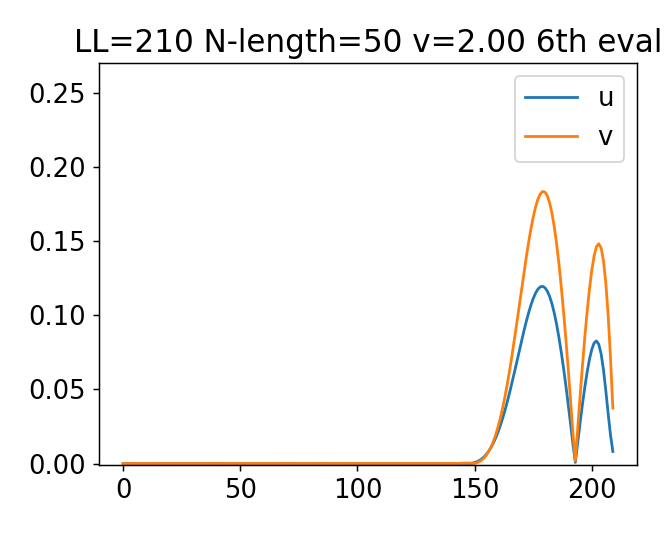

<IPython.core.display.Javascript object>


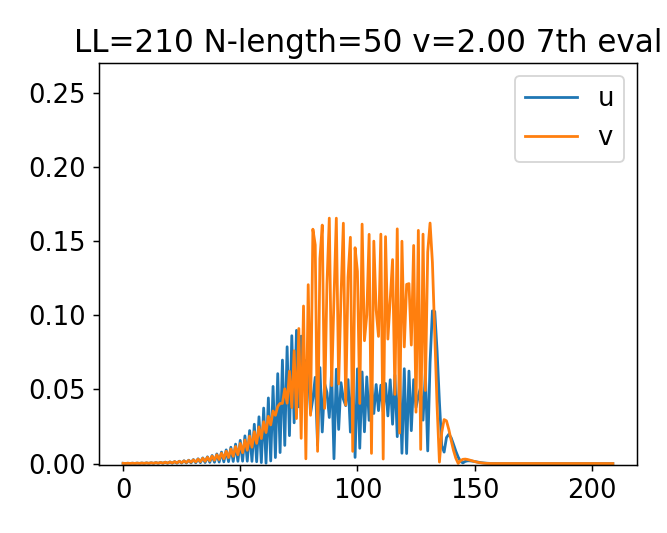

<IPython.core.display.Javascript object>


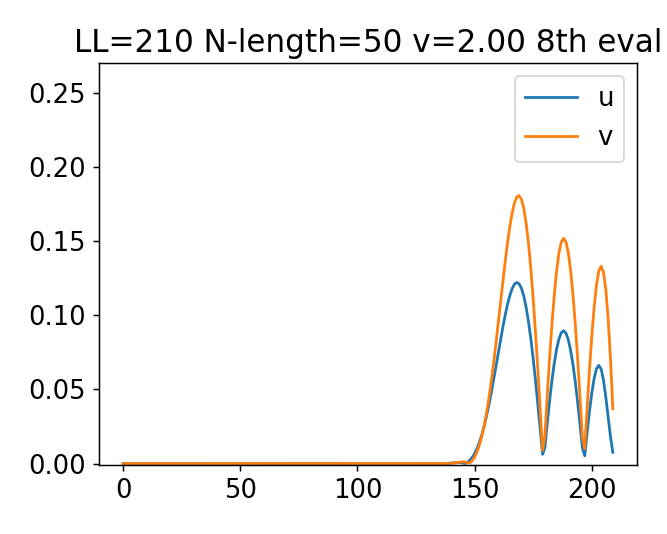

<IPython.core.display.Javascript object>


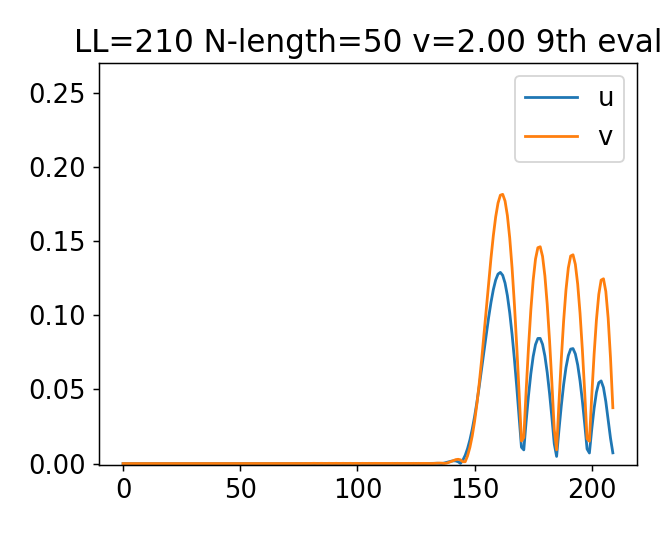

In [70]:
for i in range(0,10):
    figure, axes = plt.subplots(1,1,figsize=(5,4))
    axes.plot(np.abs(Uvecs)[:,i],label='u')
    axes.plot(np.abs(Vvecs)[:,i],label='v')
    axes.legend()
    axes.set_ylim(-0.001,0.27)
    axes.legend()
    axes.set_title('LL=%d N-length=%d v=%.2f %dth eval'% (LL,N,v,i),ha='center')
#     plt.savefig('1bandmodel-BCS-N-BEC-LL%d-N_length%d-muoffset%.2f-occu%.2f-v%.2f-%dth-uvabs.png' % (LL,N,mu_offset,occu,v,i))

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


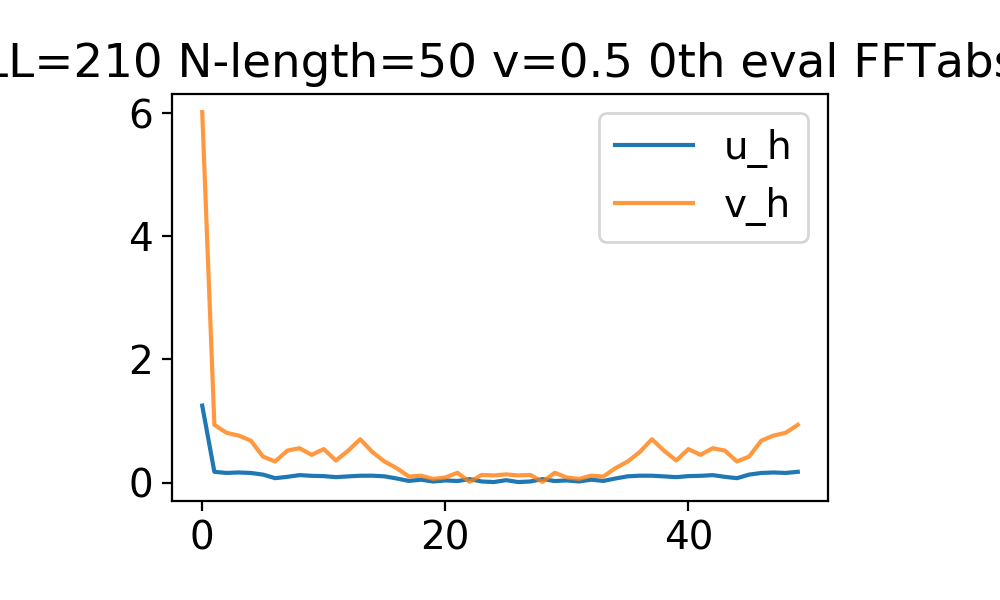

<IPython.core.display.Javascript object>


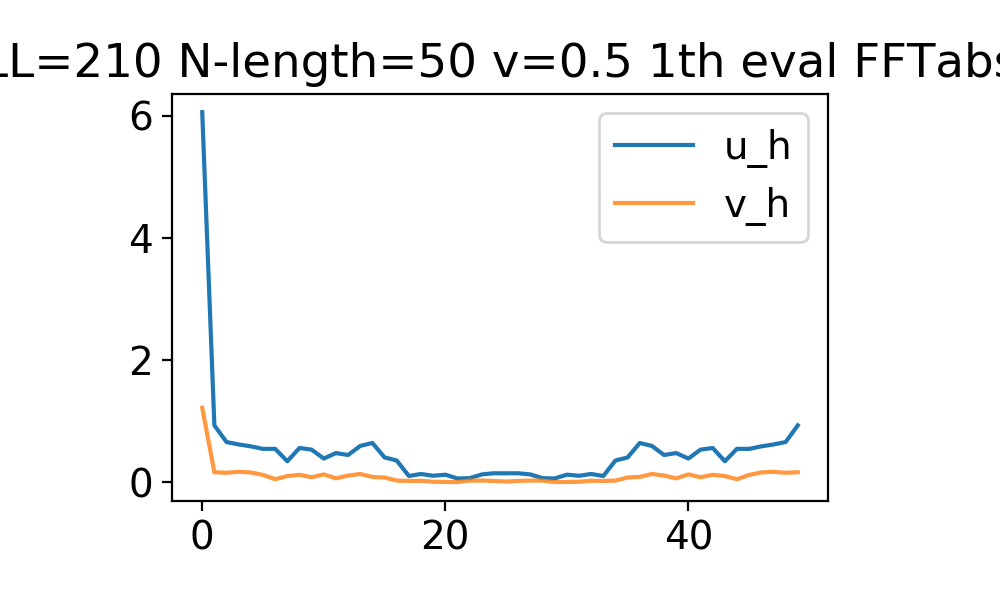

<IPython.core.display.Javascript object>


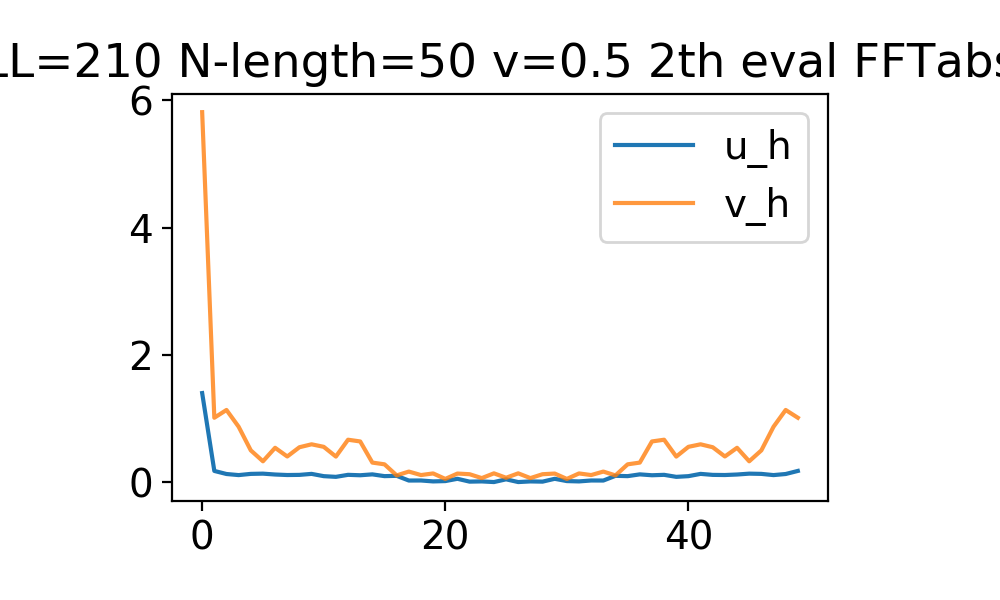

<IPython.core.display.Javascript object>


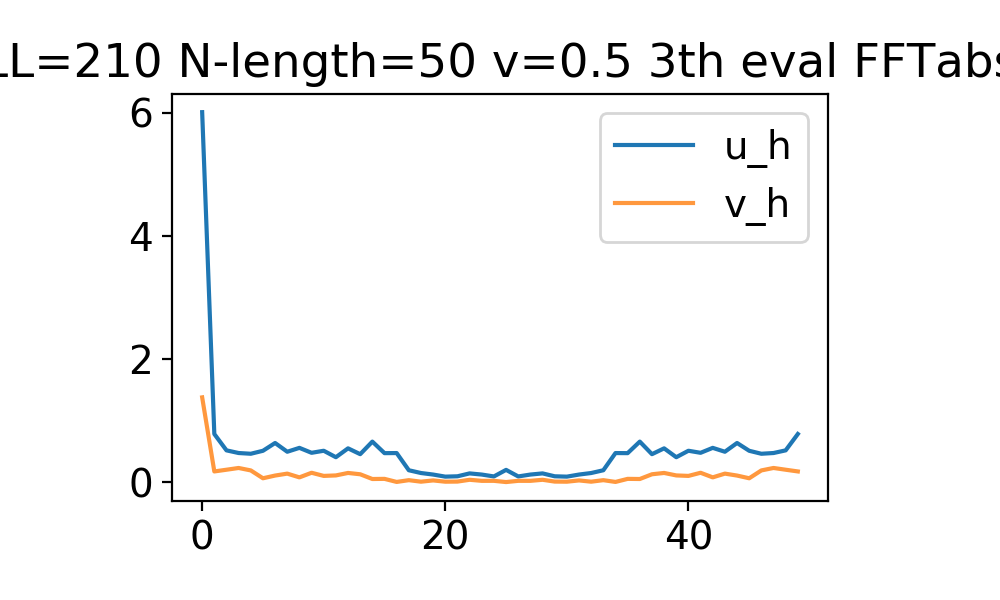

<IPython.core.display.Javascript object>


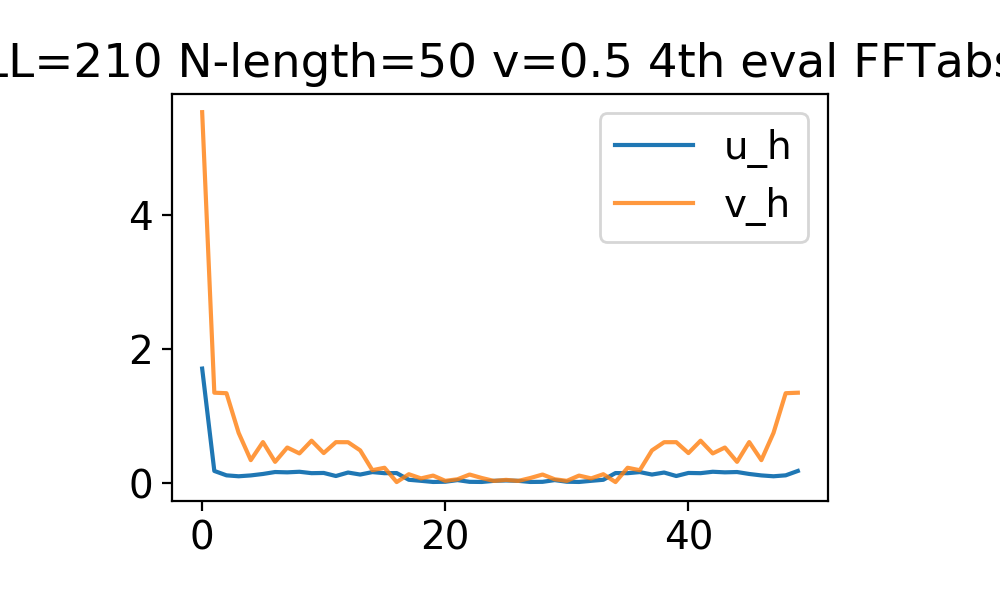

<IPython.core.display.Javascript object>


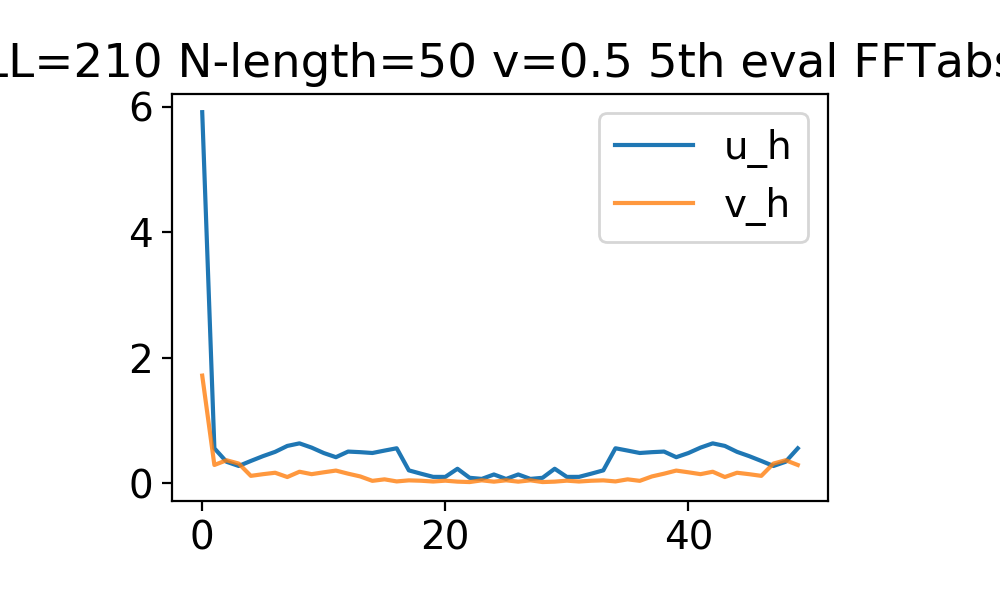

<IPython.core.display.Javascript object>


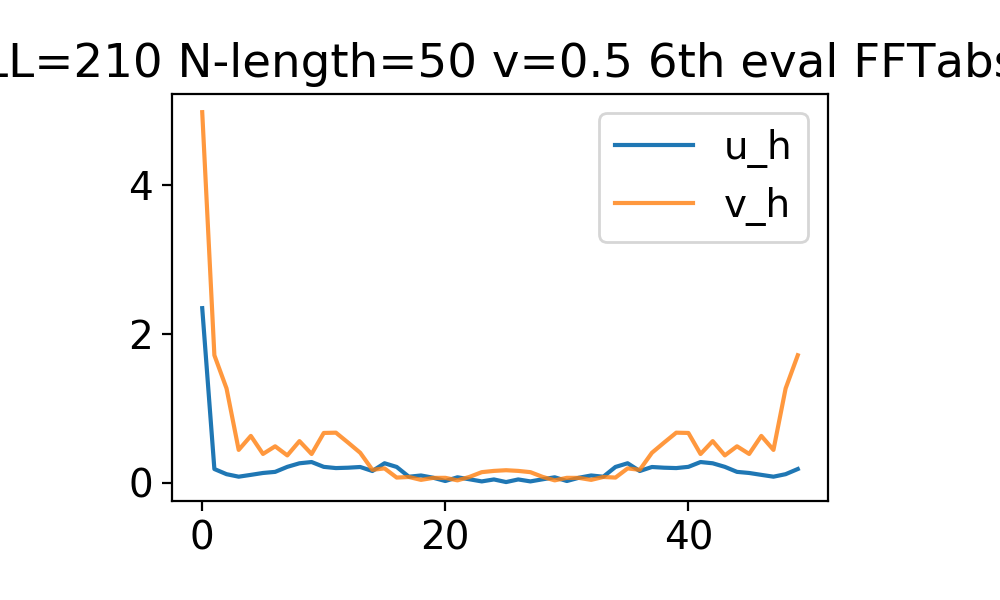

<IPython.core.display.Javascript object>


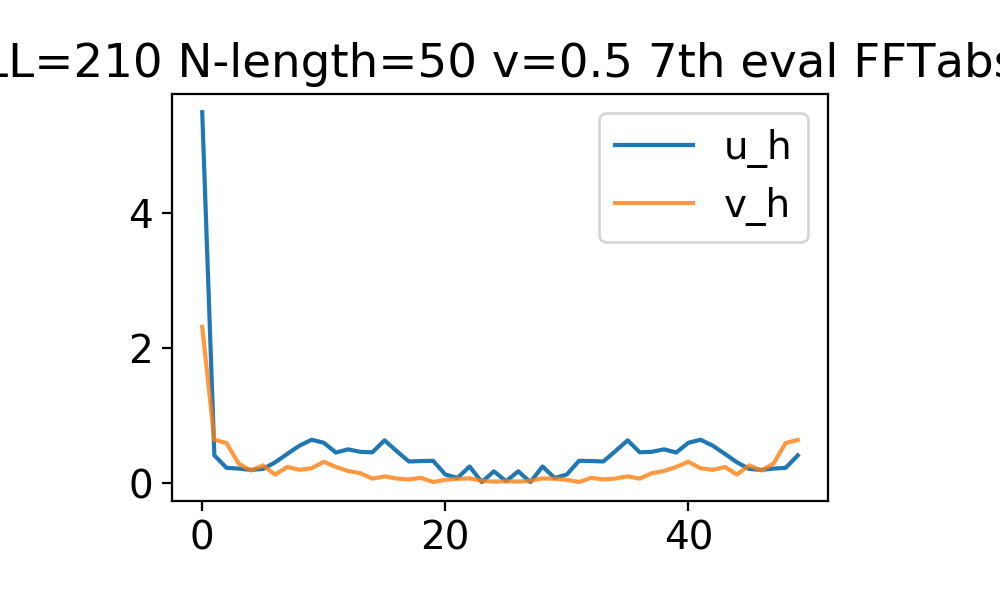

In [28]:
for i in range(0,8):
    figure, axes = plt.subplots(1,1,figsize=(5,3))
    axes.plot(np.abs(fft(np.abs(Uvecs)[80:130,i])),label='u_h')
    axes.plot(np.abs(fft(np.abs(Vvecs)[80:130,i])),label='v_h',alpha=0.8)
#     axes[1].plot(np.abs(fft(np.abs(uvecs_e)[80:130,i])),label='u_e')
#     axes[1].plot(np.abs(fft(np.abs(vvecs_e)[80:130,i])),label='v_e',alpha=0.8)
    axes.legend()
#     axes.set_ylim(-2,4.6)
#     axes[1].set_ylim(-2,4.6)
#     axes[1].legend()
    axes.set_title('LL=%d N-length=%d v=0.5 %dth eval FFTabs'% (LL,N,i),ha='center')